## Exploring differences in Atlantis output for vertebrates
Using the oil spill at English Bay as an example, this notebook explores differences in reporting total biomass of vertebrates as parameters species_N, versus collating all Res_N, Struct_N and Numbers for each cohort and summing them when doing biomass reporting for Atlantis. The Puget Sound Atlantis team uses a conversion factor from mg N to wetweight that is included at the end of the comparison, but is uniform for both control and oil spill scenarios and is not considered here. 

Conversion factor = 20 x 5.7 x (3.65/2.65)/1000000

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import itertools
from pathlib import Path
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
affected_boxes = [75, 80]
initial_box = [75]

In [3]:
# Reading in Atlantis map
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]
land_df = data_df.loc[land_boxes]
jdf_df = data_df.loc[data_df.Region=='Juan de Fuca']
hs_df = data_df.loc[data_df.Region=='Howe Sound']
strait_df = data_df.loc[data_df.Region=='Strait of Georgia']
ps_df = data_df.loc[data_df.Region=='Puget Sound']

### Define scenario and control files

In [4]:
hex_colour = '#2F61A4' # alt #8CB7D7
hatches = ['oo', '///', 'xx', '++']

In [5]:
# Read in salish sea atlantis output files.
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1')

control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/v6719_50y_VBITBUCKET-ddmove0-2-ZGppreyWS-1-PL-fishing/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)
time = np.ma.filled(control.variables['t'])


In [6]:
scenario_paths = sorted([p for p in scenario_root.glob('Scenario_6a*/outputSalishSea.nc')])
for path in scenario_paths:
    print(path.parent.stem, groups.conditions[str(path.parent.stem).split(sep = '_')[3]])

Scenario_6a_1_2019-07-16 low Fraser flow spring tide summer
Scenario_6a_2_2019-07-25 low Fraser flow neap tide summer
Scenario_6a_3_2020-07-21 high Fraser flow spring tide summer
Scenario_6a_4_2020-07-13 high Fraser flow neap tide summer


In [7]:
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]

In [8]:
# start and end time of data display, after burn-in
start = 100
end = time.size-1

In [9]:
print('closest time points to 2019 spill: ' + str(time[116]))
print('5 years post spill: ' + str((time[132])))
print('10 years post spill: ' + str(time[152]))
print('20 years post spill: ' + str(time[193]))

closest time points to 2019 spill: 2020-07-31T14:00:00.000000000
5 years post spill: 2024-07-10T14:00:00.000000000
10 years post spill: 2029-06-14T14:00:00.000000000
20 years post spill: 2039-07-22T14:00:00.000000000


In [10]:
print('closest time points to 2020 spill: ' + str(time[120]))
print('5 years post spill: ' + str((time[136])))
print('10 years post spill: ' + str(time[156]))
print('20 years post spill: ' + str(time[197]))

closest time points to 2020 spill: 2021-07-26T14:00:00.000000000
5 years post spill: 2025-07-05T14:00:00.000000000
10 years post spill: 2030-06-09T14:00:00.000000000
20 years post spill: 2040-07-16T14:00:00.000000000


In [11]:
days2019summer = [116, 132, 152, 193]
days2020summer = [120, 136, 156, 197]

In [12]:
affected_pelagic = {
    'porpoises':'Harbor_porpoise','humpbacks':'Humpback_whales',
    'small pelagic':'Small_pelagic_fish', 'hake':'Hake','sandlance':'Sandlance', 
    'pacific herring':'Pacific_herring',
}

### PAH in vertebrates

In [13]:
def plot_vertebrate_pah(species,pah, boxes=groups.salish_sea, start=start, end=end, y_min=None, y_max=None):
    for scenario, path in zip(scenario_datasets,scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        if nm[1] == '4a':
            scenario_loc = 'AP-'
        elif nm[1] == '5b':
            scenario_loc = 'TP-'
        elif nm[1] == '6a':
            scenario_loc = 'EB-'
        elif nm[1] == '7a':
            scenario_loc = 'JF-'
        scenario_name=scenario_loc+'-'+str(nm[2])
        fig, ax = plt.subplots(figsize = (14,5))
        for cohort in range (1, groups.cohorts[species]+1):
            contam_tbl = scenario.variables[species+str(cohort)+'_'+str(pah)][start:end,boxes,0:6]
            contam_t = contam_tbl.sum(axis=(1,2))
            ax.plot(scenario.t[start:end], contam_t, label='Cohort '+str(cohort))
        ax.set_title(scenario_name+' '+ pah +' in '+ species, fontsize = 12)
        ax.set_ylabel('mg PAH/m$^3$')
        ax.legend(); #loc='upper left', bbox_to_anchor=(1.05, 1), loc='upper center', 

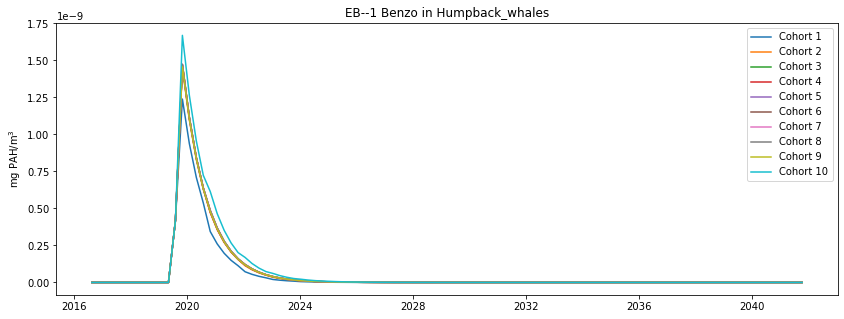

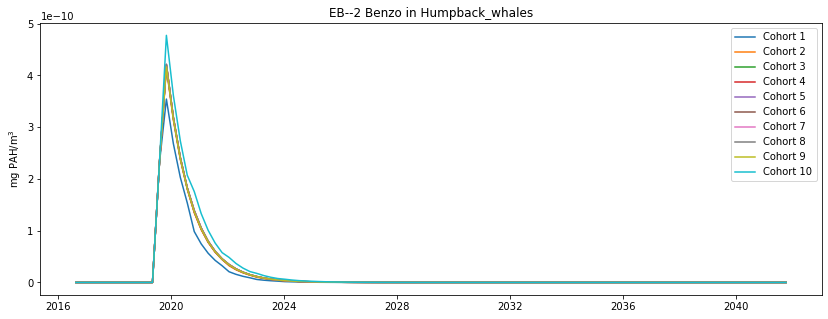

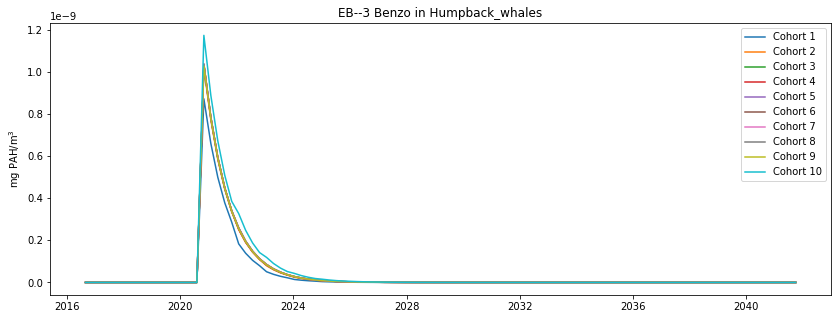

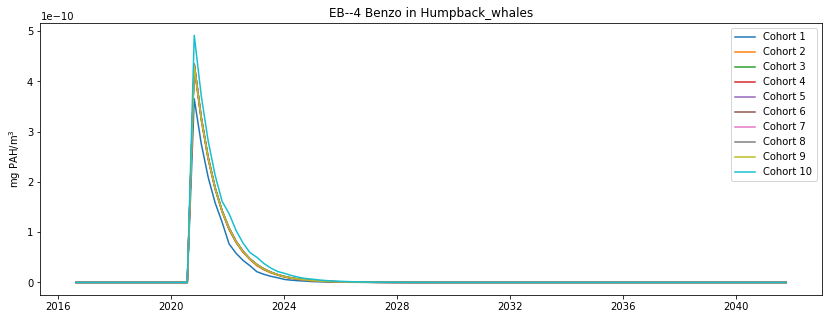

In [14]:
plot_vertebrate_pah('Humpback_whales','Benzo')

## Cohorts time series

In [13]:
def compare_cohorts_loglog(bio_group, boxes):
    font_size = 14
    label_size = 12
    line_width = 1.5

    for species in bio_group:

        #fig = plt.figure(figsize=(4, 16), facecolor='white')
        #gs = plt.GridSpec(1, 4, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1], )
        fig, ax = plt.subplots(1,4, figsize = (16,4), sharey='all')
        numCohorts = groups.cohorts[bio_group[species]]

        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'EB-'+nm[2]  

            plot_index = (list(scenario_paths).index(path))

            for cohort in range (1, numCohorts+1):

                new_species = bio_group[species] + str(cohort)
            
                o_numbers_tbl = np.ma.filled(scenario.variables[new_species + '_Nums'][start:end,boxes,0:6], np.nan)
                o_structuralN_tbl = np.ma.filled(scenario.variables[new_species +'_StructN'][start:end,boxes,0:6], np.nan)
                o_reservedN_tbl = np.ma.filled(scenario.variables[new_species +'_ResN'][start:end,boxes,0:6], np.nan)

                c_numbers_tbl = np.ma.filled(control.variables[new_species + '_Nums'][start:end,boxes,0:6], np.nan)
                c_structuralN_tbl = np.ma.filled(control.variables[new_species +'_StructN'][start:end,boxes,0:6], np.nan)
                c_reservedN_tbl = np.ma.filled(control.variables[new_species +'_ResN'][start:end,boxes,0:6], np.nan)

                o_weightatage_tbl = (o_structuralN_tbl + o_reservedN_tbl) * o_numbers_tbl 
                o_weightatage_t = o_weightatage_tbl.sum(axis=(1,2))

                c_weightatage_tbl = (c_structuralN_tbl + c_reservedN_tbl) * c_numbers_tbl 
                c_weightatage_t = c_weightatage_tbl.sum(axis=(1,2))

                #difference = o_weightatage_tb.sum(axis=1) - c_weightatage_tb.sum(axis=1) 
                #ratio = (o_weightatage_tb.sum(axis=1) / c_weightatage_tb.sum(axis=1) - 1) * 100

                ax[plot_index].loglog(c_weightatage_t, o_weightatage_t, '.', alpha=0.5, label='cohort '+str(cohort))
            #ax[plot_index].loglog((c_weightatage_t.min(),c_weightatage_t.max()),(c_weightatage_t.min(),c_weightatage_t.max()),linewidth = line_width,alpha=0.3,color='black')
                #ax[plot_index].plot(time[start:end],  linewidth = line_width)
            #ax[plot_index].fill_between(time[start:end], -groups.sensitivity[species], groups.sensitivity[species],
            #    color='grey', alpha=0.3, label='model tolerance')
                
            ax[plot_index].set_title(str(bio_group[species])+' - '+scenario_name, fontsize = font_size)
            ax[plot_index].tick_params(labelsize=label_size)
            ax[plot_index].set_xlabel('Scenario Biomass', fontsize = font_size)
        ax[0].set_ylabel('Control Biomass', fontsize = font_size)
        ax[0].legend() #loc='center left'
        

In [35]:
def plot_cohort_biomass(bio_group, boxes):
    font_size = 14
    label_size = 12
    line_width = 1.5

    for species in bio_group:

        #fig = plt.figure(figsize=(4, 16), facecolor='white')
        #gs = plt.GridSpec(1, 4, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1], )
        fig, ax = plt.subplots(4,1, figsize = (16,16), sharex='all')
        numCohorts = groups.cohorts[bio_group[species]]

        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'EB-'+nm[2]  

            plot_index = (list(scenario_paths).index(path))

            for cohort in range (1, numCohorts+1):

                new_species = bio_group[species] + str(cohort)
            
                o_numbers_tbl = np.ma.filled(scenario.variables[new_species + '_Nums'][start:end,boxes,0:6], np.nan)
                o_structuralN_tbl = np.ma.filled(scenario.variables[new_species +'_StructN'][start:end,boxes,0:6], np.nan)
                o_reservedN_tbl = np.ma.filled(scenario.variables[new_species +'_ResN'][start:end,boxes,0:6], np.nan)

                c_numbers_tbl = np.ma.filled(control.variables[new_species + '_Nums'][start:end,boxes,0:6], np.nan)
                c_structuralN_tbl = np.ma.filled(control.variables[new_species +'_StructN'][start:end,boxes,0:6], np.nan)
                c_reservedN_tbl = np.ma.filled(control.variables[new_species +'_ResN'][start:end,boxes,0:6], np.nan)

                o_weightatage_tbl = (o_structuralN_tbl + o_reservedN_tbl) * o_numbers_tbl 
                o_weightatage_t = o_weightatage_tbl.sum(axis=(1,2))

                c_weightatage_tbl = (c_structuralN_tbl + c_reservedN_tbl) * c_numbers_tbl 
                c_weightatage_t = c_weightatage_tbl.sum(axis=(1,2))

                #difference = o_weightatage_tb.sum(axis=1) - c_weightatage_tb.sum(axis=1) 
                #ratio = (o_weightatage_tb.sum(axis=1) / c_weightatage_tb.sum(axis=1) - 1) * 100

                ax[plot_index].semilogy(control.t[start:end], c_weightatage_t, 'k--')
                ax[plot_index].semilogy(scenario.t[start:end], o_weightatage_t,label='cohort '+str(cohort))
            #ax[plot_index].loglog((c_weightatage_t.min(),c_weightatage_t.max()),(c_weightatage_t.min(),c_weightatage_t.max()),linewidth = line_width,alpha=0.3,color='black')
                #ax[plot_index].plot(time[start:end],  linewidth = line_width)
            #ax[plot_index].fill_between(time[start:end], -groups.sensitivity[species], groups.sensitivity[species],
            #    color='grey', alpha=0.3, label='model tolerance')
            ax[plot_index].set_title(str(bio_group[species])+' - '+scenario_name, fontsize = font_size)
            ax[plot_index].tick_params(labelsize=label_size)
        ax[0].set_ylabel('Biomass', fontsize = font_size)
        ax[0].legend() #loc='center left'
        

In [15]:
def compare_cohort_biomass_totals1(bio_group, boxes):
    font_size = 14
    label_size = 12
    line_width = 1.5

    for species in bio_group:

        #fig = plt.figure(figsize=(4, 16), facecolor='white')
        #gs = plt.GridSpec(1, 4, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1], )
        fig, ax = plt.subplots(4,1, figsize = (16,16), sharey='all')
        numCohorts = groups.cohorts[bio_group[species]]

        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'EB-'+nm[2]  

            c_nums = 0
            s_nums = 0
            total_weight = 0

            plot_index = (list(scenario_paths).index(path))

            control_tbl = np.ma.filled(control.variables[bio_group[species] + '_N'][start:end,boxes,0:6], np.nan)
            control_t = control_tbl.sum(axis=(1,2))
            scenario_tbl = np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:end,boxes,0:6], np.nan)
            scenario_t = scenario_tbl.sum(axis=(1,2))

            for cohort in range (1, numCohorts+1):

                new_species = bio_group[species] + str(cohort)
            
                o_numbers_tbl = np.ma.filled(scenario.variables[new_species + '_Nums'][start:end,boxes,0:6], np.nan)
                o_structuralN_tbl = np.ma.filled(scenario.variables[new_species +'_StructN'][start:end,boxes,0:6], np.nan)
                o_reservedN_tbl = np.ma.filled(scenario.variables[new_species +'_ResN'][start:end,boxes,0:6], np.nan)

                c_numbers_tbl = np.ma.filled(control.variables[new_species + '_Nums'][start:end,boxes,0:6], np.nan)
                #c_structuralN_tbl = np.ma.filled(control.variables[new_species +'_StructN'][start:end,boxes,:], np.nan)
                #c_reservedN_tbl = np.ma.filled(control.variables[new_species +'_ResN'][start:end,boxes,:], np.nan)

                o_weightatage_tbl = (o_structuralN_tbl + o_reservedN_tbl) * o_numbers_tbl 
                o_weightatage_t = o_weightatage_tbl.sum(axis=(1,2))

                #c_weightatage_tbl = (c_structuralN_tbl + c_reservedN_tbl * c_numbers_tbl) 
                #c_weightatage_t = c_weightatage_tbl.sum(axis=(1,2))
                c_nums = c_nums + c_numbers_tbl.sum(axis=(1,2))
                s_nums = s_nums + o_numbers_tbl.sum(axis=(1,2))
                total_weight = total_weight + o_weightatage_t
                #difference = o_weightatage_tb.sum(axis=1) - c_weightatage_tb.sum(axis=1) 
                #ratio = (o_weightatage_tb.sum(axis=1) / c_weightatage_tb.sum(axis=1) - 1) * 100

                ax[plot_index].semilogy(scenario.t[start:end], o_weightatage_t, alpha=0.5,label='cohort '+str(cohort))
            #ax[plot_index].loglog((c_weightatage_t.min(),c_weightatage_t.max()),(c_weightatage_t.min(),c_weightatage_t.max()),linewidth = line_width,alpha=0.3,color='black')
                #ax[plot_index].plot(time[start:end],  linewidth = line_width)
            #ax[plot_index].fill_between(time[start:end], -groups.sensitivity[species], groups.sensitivity[species],
            #    color='grey', alpha=0.3, label='model tolerance')
            ax[plot_index].semilogy(control.t[start:end], control_t*c_nums, 'k.') #label='control_N*Nums'
            ax[plot_index].semilogy(scenario.t[start:end], scenario_t*s_nums, '.', color=hex_colour, label='scenario_N*Nums')   
            ax[plot_index].semilogy(scenario.t[start:end], total_weight, '--', color=hex_colour, label='total weight', linewidth = 1.5)   
            ax[plot_index].semilogy(control.t[start:end], control_t, 'k.') #label='control_N'
            ax[plot_index].semilogy(scenario.t[start:end], scenario_t, '.', color='red', label='scenario_N')   
            ax[plot_index].set_title(str(bio_group[species])+' - '+scenario_name, fontsize = font_size)
            ax[plot_index].tick_params(labelsize=label_size)
        ax[0].set_ylabel('Biomass (mg N / m$^3$)', fontsize = font_size)
        ax[0].legend(bbox_to_anchor=(1.05, 1)) #loc='center left' ncol=numCohorts+1
        

In [16]:
def compare_cohort_biomass_totals2(bio_group, boxes):
    font_size = 14
    label_size = 12
    line_width = 1.5

    for species in bio_group:

        #fig = plt.figure(figsize=(4, 16), facecolor='white')
        #gs = plt.GridSpec(1, 4, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1], )
        fig, ax = plt.subplots(4,1, figsize = (16,16), sharey='all')
        numCohorts = groups.cohorts[bio_group[species]]

        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'EB-'+nm[2]  

            c_nums = 0
            s_nums = 0
            total_weight = 0

            plot_index = (list(scenario_paths).index(path))

            control_tbl = np.ma.filled(control.variables[bio_group[species] + '_N'][start:end,boxes,0:6], np.nan)
            control_t = control_tbl.sum(axis=(1,2))
            scenario_tbl = np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:end,boxes,0:6], np.nan)
            scenario_t = scenario_tbl.sum(axis=(1,2))

            for cohort in range (1, numCohorts+1):

                new_species = bio_group[species] + str(cohort)
            
                o_numbers_tbl = np.ma.filled(scenario.variables[new_species + '_Nums'][start:end,boxes,0:6], np.nan)
                o_structuralN_tbl = np.ma.filled(scenario.variables[new_species +'_StructN'][start:end,boxes,0:6], np.nan)
                o_reservedN_tbl = np.ma.filled(scenario.variables[new_species +'_ResN'][start:end,boxes,0:6], np.nan)

                c_numbers_tbl = np.ma.filled(control.variables[new_species + '_Nums'][start:end,boxes,0:6], np.nan)
                #c_structuralN_tbl = np.ma.filled(control.variables[new_species +'_StructN'][start:end,boxes,:], np.nan)
                #c_reservedN_tbl = np.ma.filled(control.variables[new_species +'_ResN'][start:end,boxes,:], np.nan)

                o_weightatage_tbl = (o_structuralN_tbl + o_reservedN_tbl) * o_numbers_tbl
                o_weightatage_t = o_weightatage_tbl.sum(axis=(1,2))

                #c_weightatage_tbl = (c_structuralN_tbl + c_reservedN_tbl * c_numbers_tbl) 
                #c_weightatage_t = c_weightatage_tbl.sum(axis=(1,2))
                c_nums = c_nums + c_numbers_tbl.sum(axis=(1,2))
                s_nums = s_nums + o_numbers_tbl.sum(axis=(1,2))
                total_weight = total_weight + o_weightatage_t
                #difference = o_weightatage_tb.sum(axis=1) - c_weightatage_tb.sum(axis=1) 
                #ratio = (o_weightatage_tb.sum(axis=1) / c_weightatage_tb.sum(axis=1) - 1) * 100

                ax[plot_index].semilogy(scenario.t[start:end], o_weightatage_t, alpha=0.5, label='cohort '+str(cohort))
            #ax[plot_index].loglog((c_weightatage_t.min(),c_weightatage_t.max()),(c_weightatage_t.min(),c_weightatage_t.max()),linewidth = line_width,alpha=0.3,color='black')
                #ax[plot_index].plot(time[start:end],  linewidth = line_width)
            #ax[plot_index].fill_between(time[start:end], -groups.sensitivity[species], groups.sensitivity[species],
            #    color='grey', alpha=0.3, label='model tolerance')
            ax[plot_index].semilogy(control.t[start:end], control_t*c_nums, 'k.') #label='control_N*Nums'
            ax[plot_index].semilogy(scenario.t[start:end], scenario_t*s_nums, '.', color=hex_colour, label='scenario_N*Nums')   
            ax[plot_index].semilogy(scenario.t[start:end], total_weight, '--', color=hex_colour, label='total weight', linewidth = 1.5)     
            ax[plot_index].set_title(str(bio_group[species])+' - '+scenario_name, fontsize = font_size)
            ax[plot_index].tick_params(labelsize=label_size)
        ax[0].set_ylabel('Biomass (mg N / m$^3$)', fontsize = font_size)
        ax[0].legend(bbox_to_anchor=(1.05, 1)) #loc='center left'
        

In [17]:
def compare_cohort_biomass_mean(bio_group, boxes):
    font_size = 14
    label_size = 12
    line_width = 1.5

    for species in bio_group:

        #fig = plt.figure(figsize=(4, 16), facecolor='white')
        #gs = plt.GridSpec(1, 4, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1], )
        fig, ax = plt.subplots(4,1, figsize = (16,16), sharey='all')
        numCohorts = groups.cohorts[bio_group[species]]

        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'EB-'+nm[2]  

            c_nums = 0
            s_nums = 0
            total_weight = 0

            plot_index = (list(scenario_paths).index(path))

            control_tbl = np.ma.filled(control.variables[bio_group[species] + '_N'][start:end,boxes,0:6], np.nan)
            control_t = control_tbl.sum(axis=(1,2))
            scenario_tbl = np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:end,boxes,0:6], np.nan)
            scenario_t = scenario_tbl.sum(axis=(1,2))

            for cohort in range (1, numCohorts+1):

                new_species = bio_group[species] + str(cohort)
            
                o_numbers_tbl = np.ma.filled(scenario.variables[new_species + '_Nums'][start:end,boxes,0:6], np.nan)
                o_structuralN_tbl = np.ma.filled(scenario.variables[new_species +'_StructN'][start:end,boxes,0:6], np.nan)
                o_reservedN_tbl = np.ma.filled(scenario.variables[new_species +'_ResN'][start:end,boxes,0:6], np.nan)

                c_numbers_tbl = np.ma.filled(control.variables[new_species + '_Nums'][start:end,boxes,0:6], np.nan)
                #c_structuralN_tbl = np.ma.filled(control.variables[new_species +'_StructN'][start:end,boxes,:], np.nan)
                #c_reservedN_tbl = np.ma.filled(control.variables[new_species +'_ResN'][start:end,boxes,:], np.nan)

                o_weightatage_tbl = (o_structuralN_tbl + o_reservedN_tbl) * o_numbers_tbl 
                o_weightatage_t = o_weightatage_tbl.sum(axis=(1,2))

                #c_weightatage_tbl = (c_structuralN_tbl + c_reservedN_tbl * c_numbers_tbl) 
                #c_weightatage_t = c_weightatage_tbl.sum(axis=(1,2))
                c_nums = c_nums + c_numbers_tbl.sum(axis=(1,2))
                s_nums = s_nums + o_numbers_tbl.sum(axis=(1,2))
                total_weight = total_weight + o_weightatage_t
                #difference = o_weightatage_tb.sum(axis=1) - c_weightatage_tb.sum(axis=1) 
                #ratio = (o_weightatage_tb.sum(axis=1) / c_weightatage_tb.sum(axis=1) - 1) * 100

                ax[plot_index].semilogy(scenario.t[start:end], o_weightatage_t, alpha=0.5, label='cohort '+str(cohort))
            #ax[plot_index].loglog((c_weightatage_t.min(),c_weightatage_t.max()),(c_weightatage_t.min(),c_weightatage_t.max()),linewidth = line_width,alpha=0.3,color='black')
                #ax[plot_index].plot(time[start:end],  linewidth = line_width)
            #ax[plot_index].fill_between(time[start:end], -groups.sensitivity[species], groups.sensitivity[species],
            #    color='grey', alpha=0.3, label='model tolerance')
            ax[plot_index].semilogy(control.t[start:end], control_t*c_nums, 'k.') #label='control_N*Nums'
            ax[plot_index].semilogy(scenario.t[start:end], scenario_t*s_nums, '.', color=hex_colour, label='scenario_N*Nums')   
            ax[plot_index].semilogy(scenario.t[start:end], total_weight/numCohorts, 'k--', label='mean weight', linewidth = 2)     
            ax[plot_index].set_title(str(bio_group[species])+' - '+scenario_name, fontsize = font_size)
            ax[plot_index].tick_params(labelsize=label_size)
        ax[0].set_ylabel('Biomass (mg N / m$^3$)', fontsize = font_size)
        ax[0].legend(bbox_to_anchor=(1.05, 1)) #loc='center left'
        

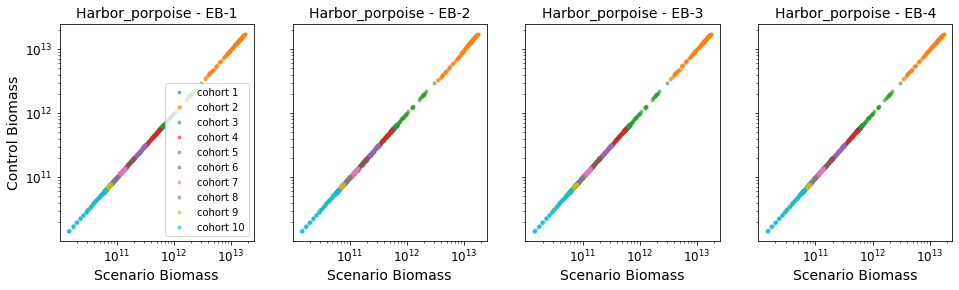

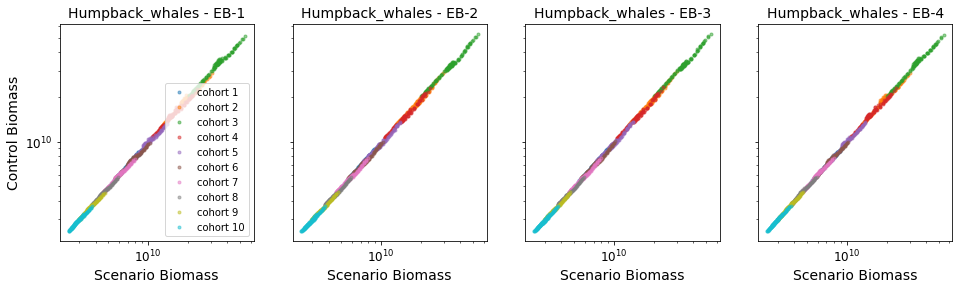

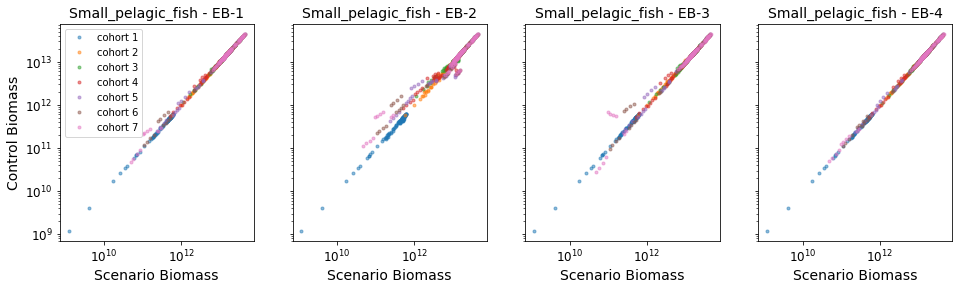

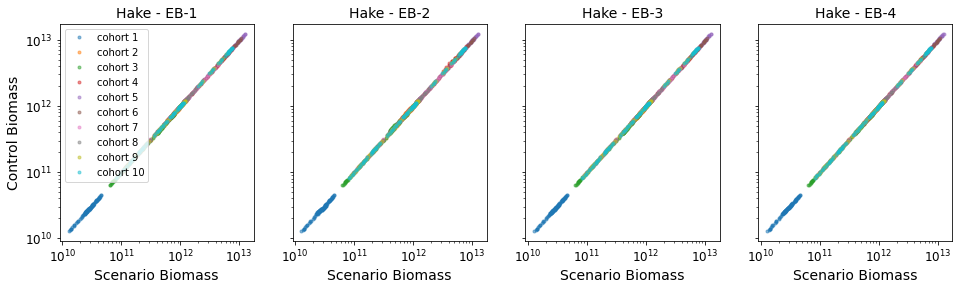

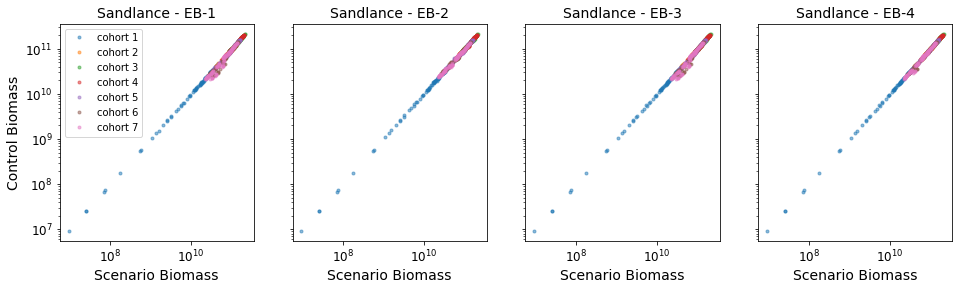

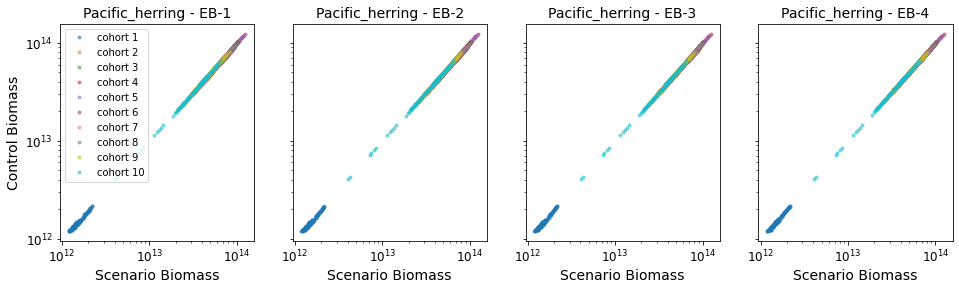

In [18]:
compare_cohorts_loglog(affected_pelagic, boxes=groups.salish_sea)

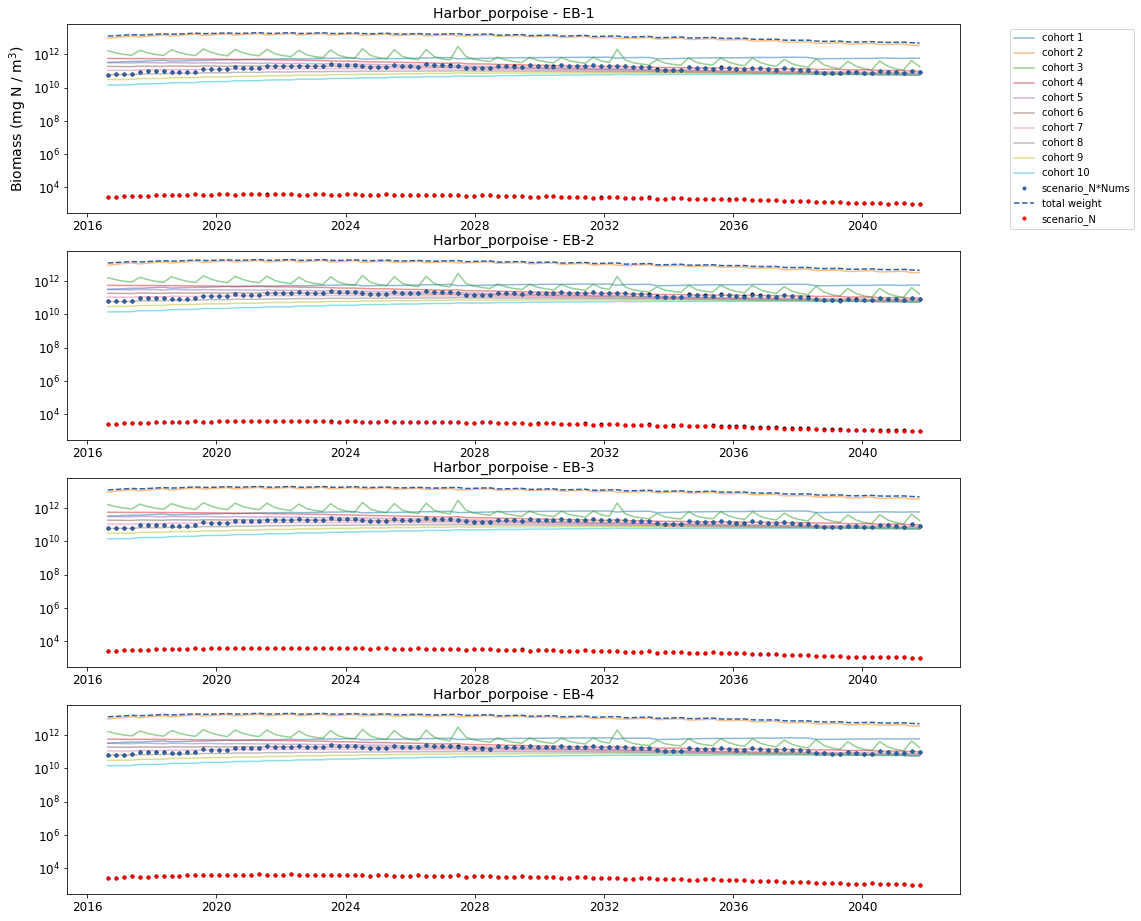

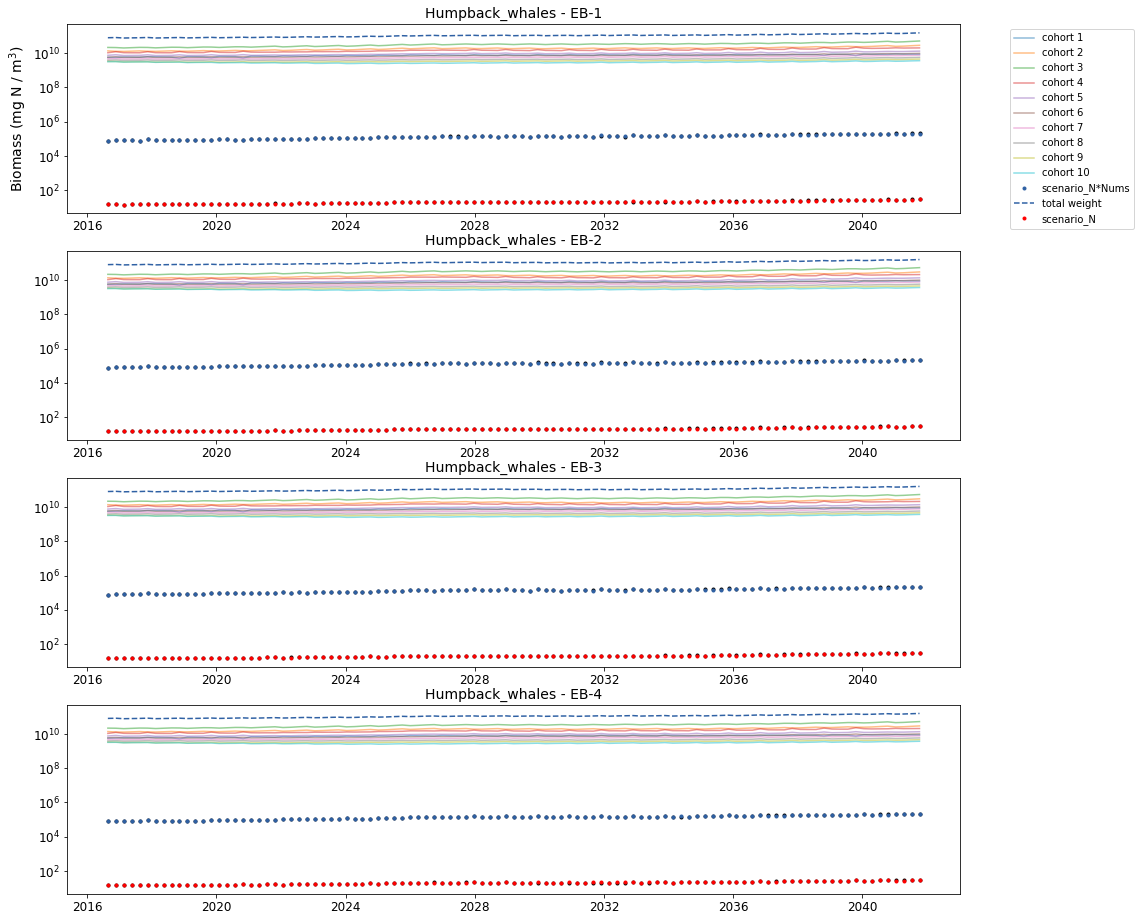

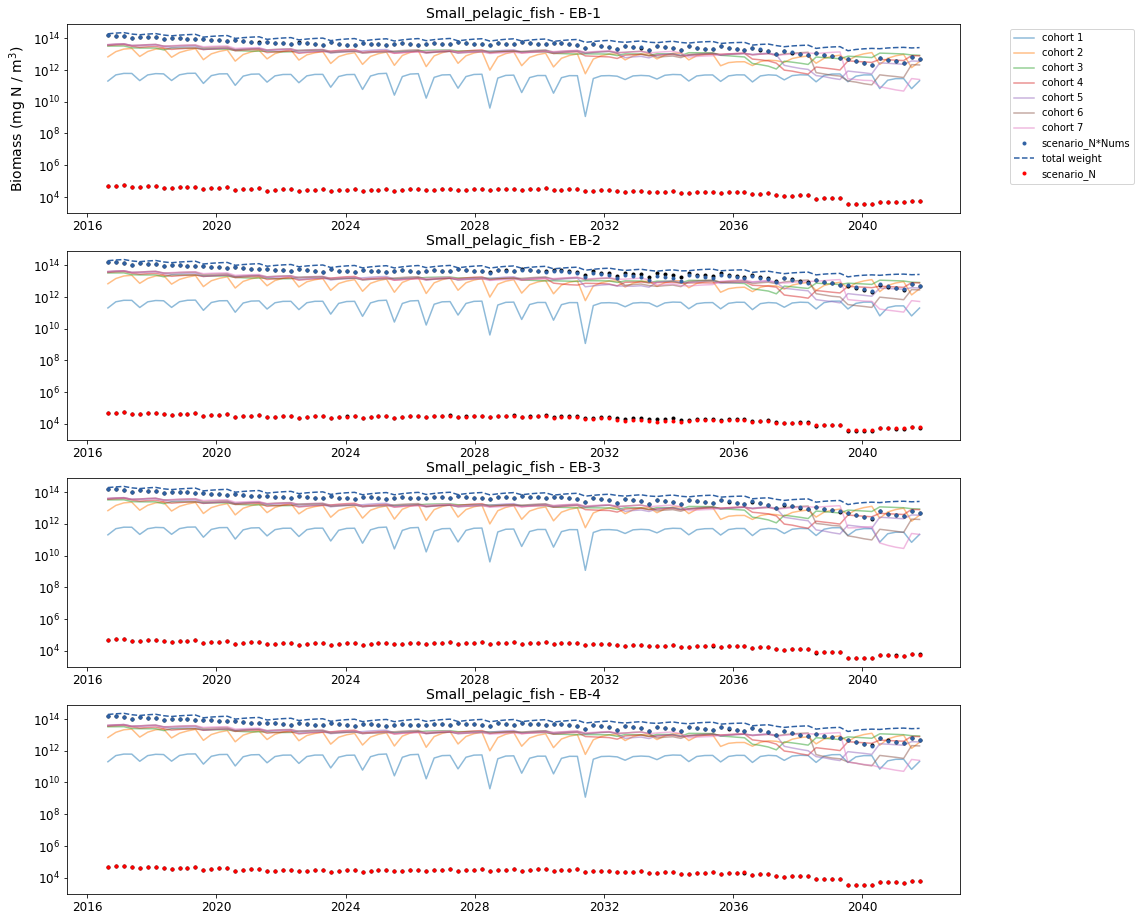

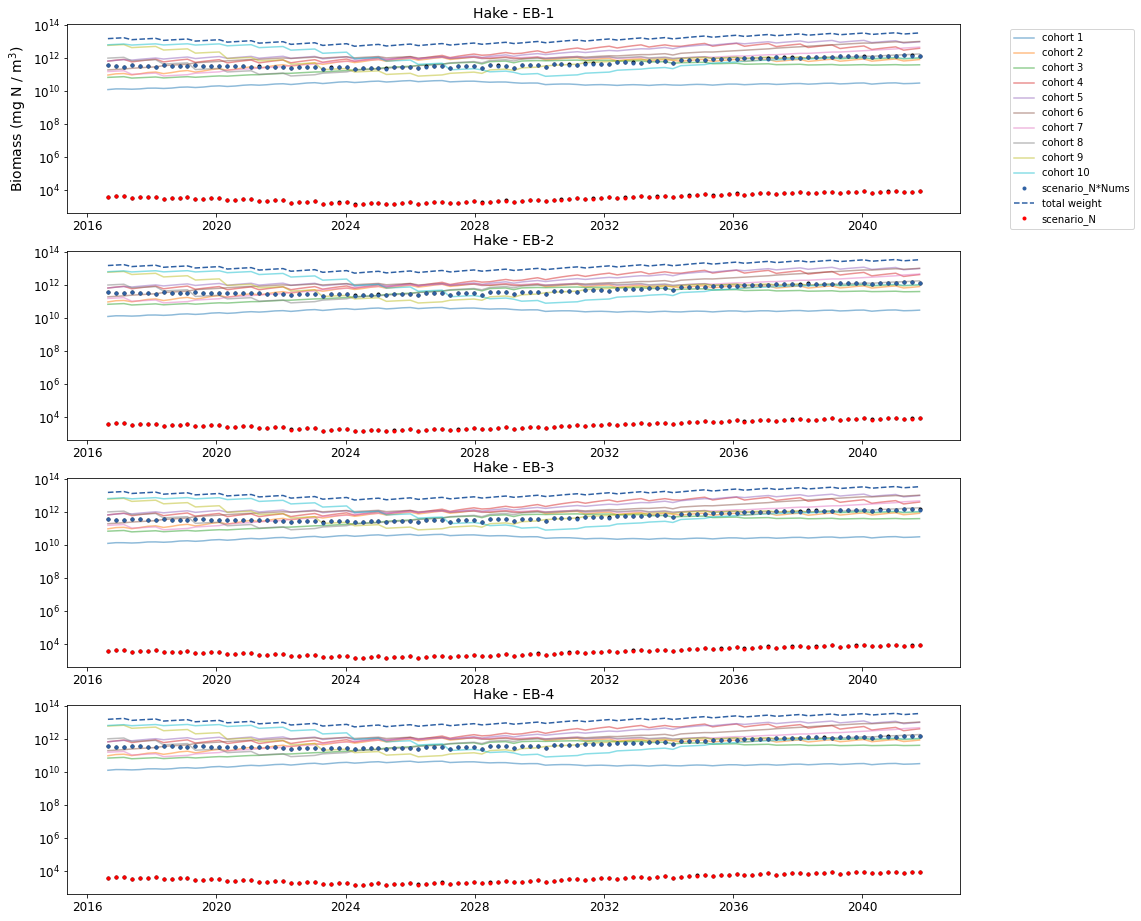

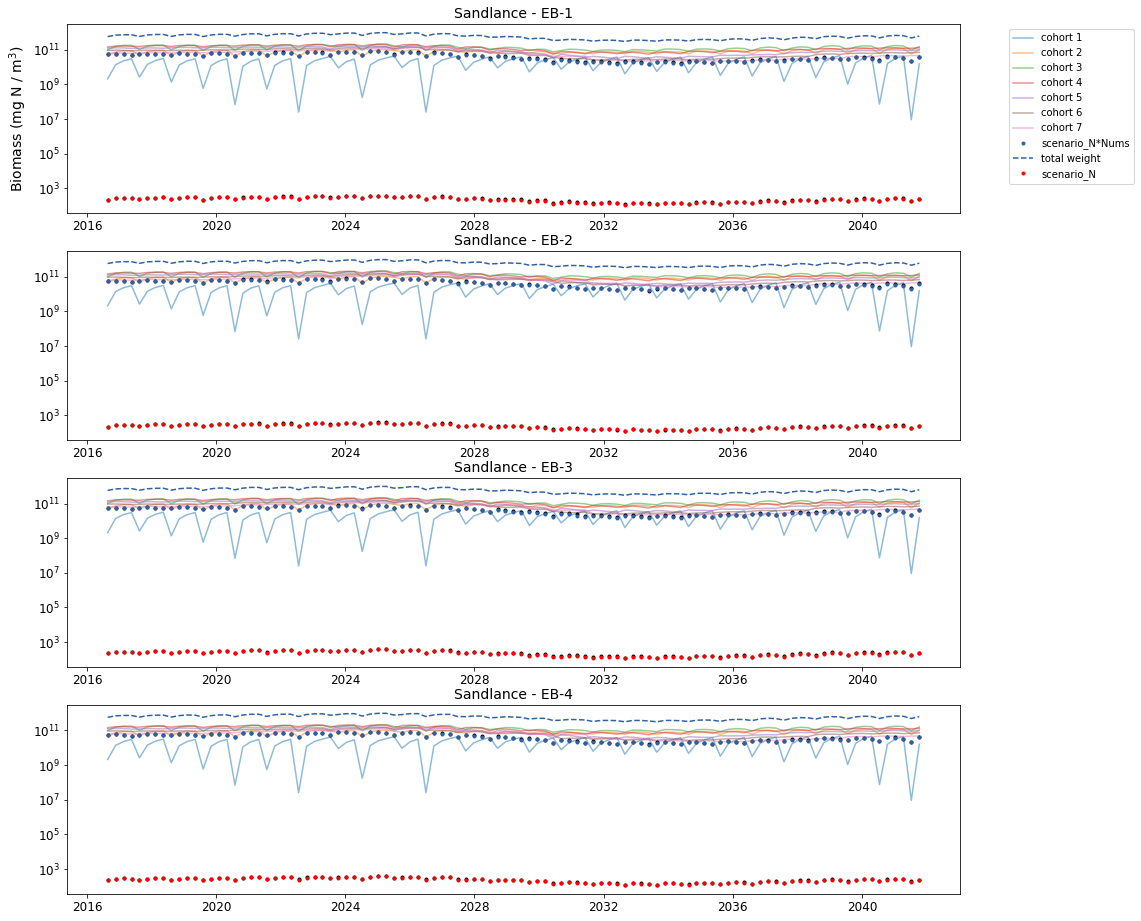

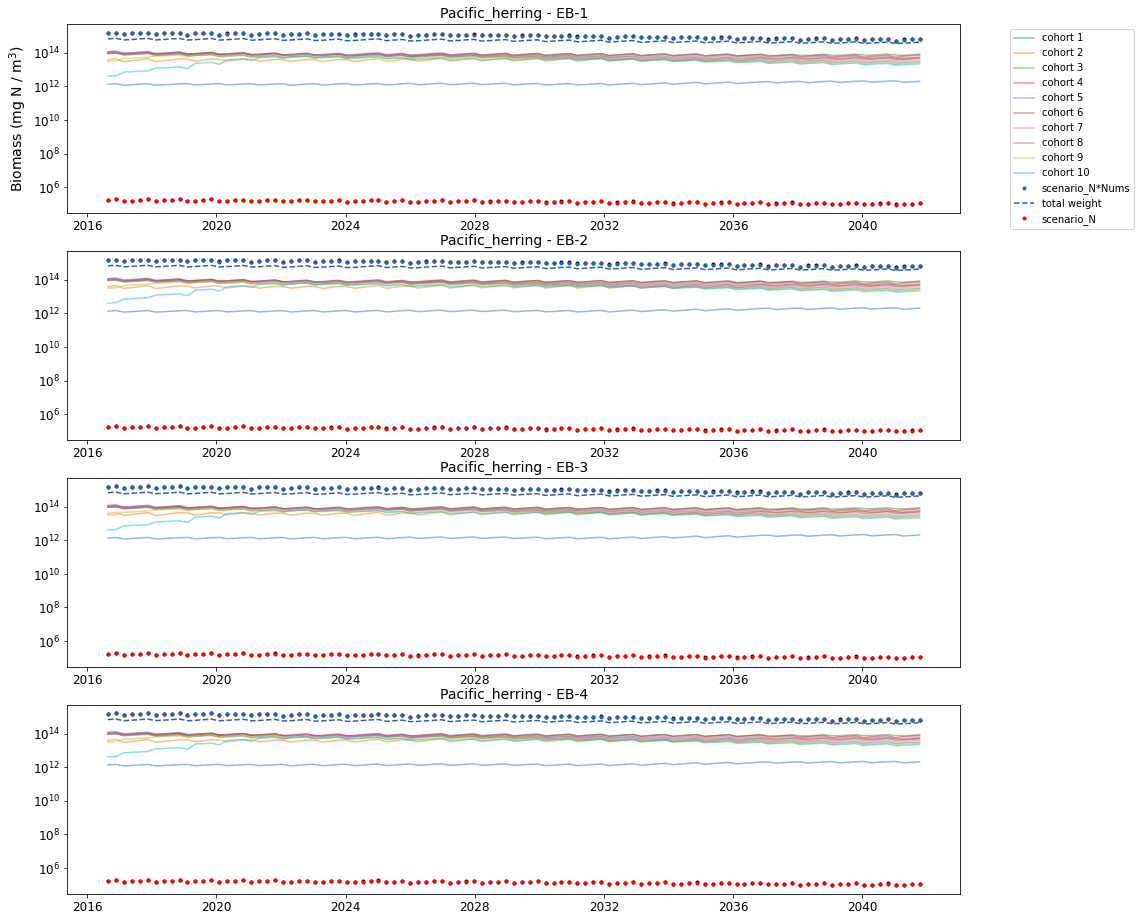

In [19]:
compare_cohort_biomass_totals1(affected_pelagic, boxes=groups.salish_sea)

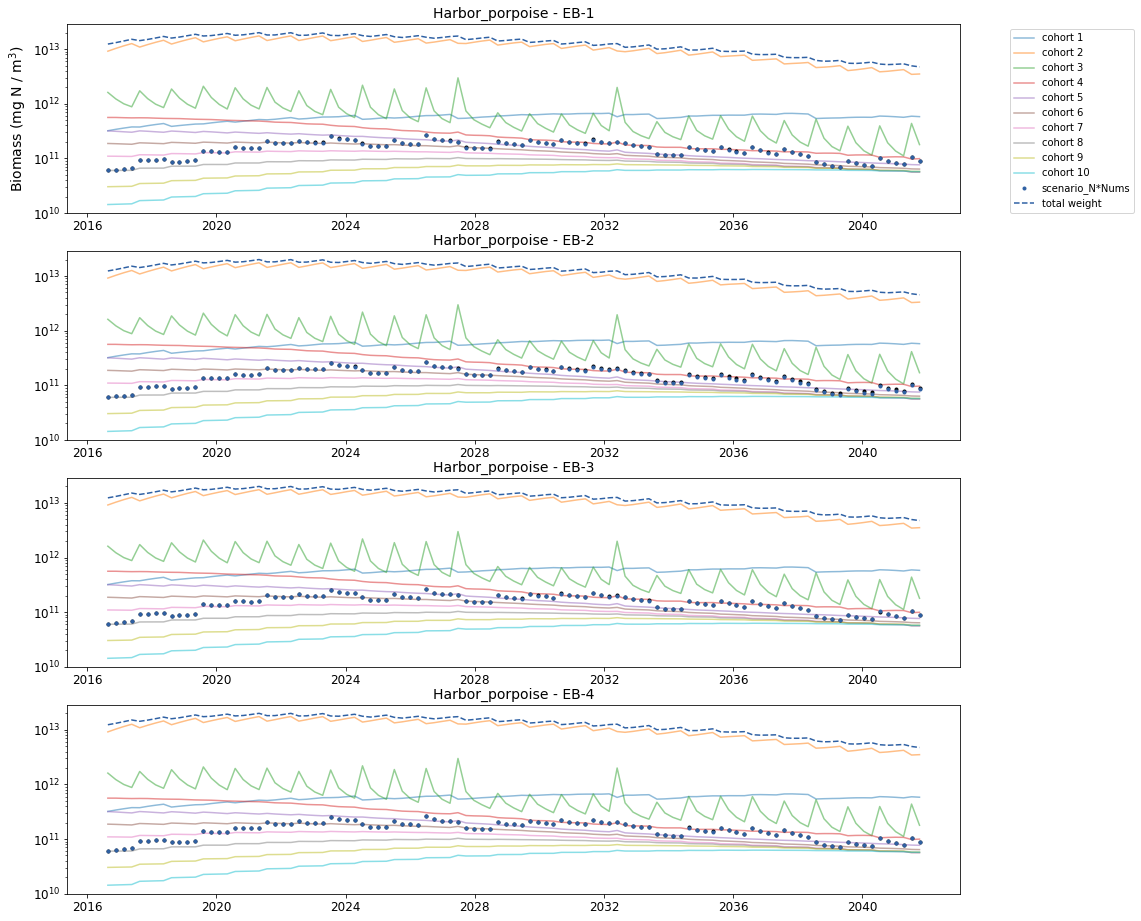

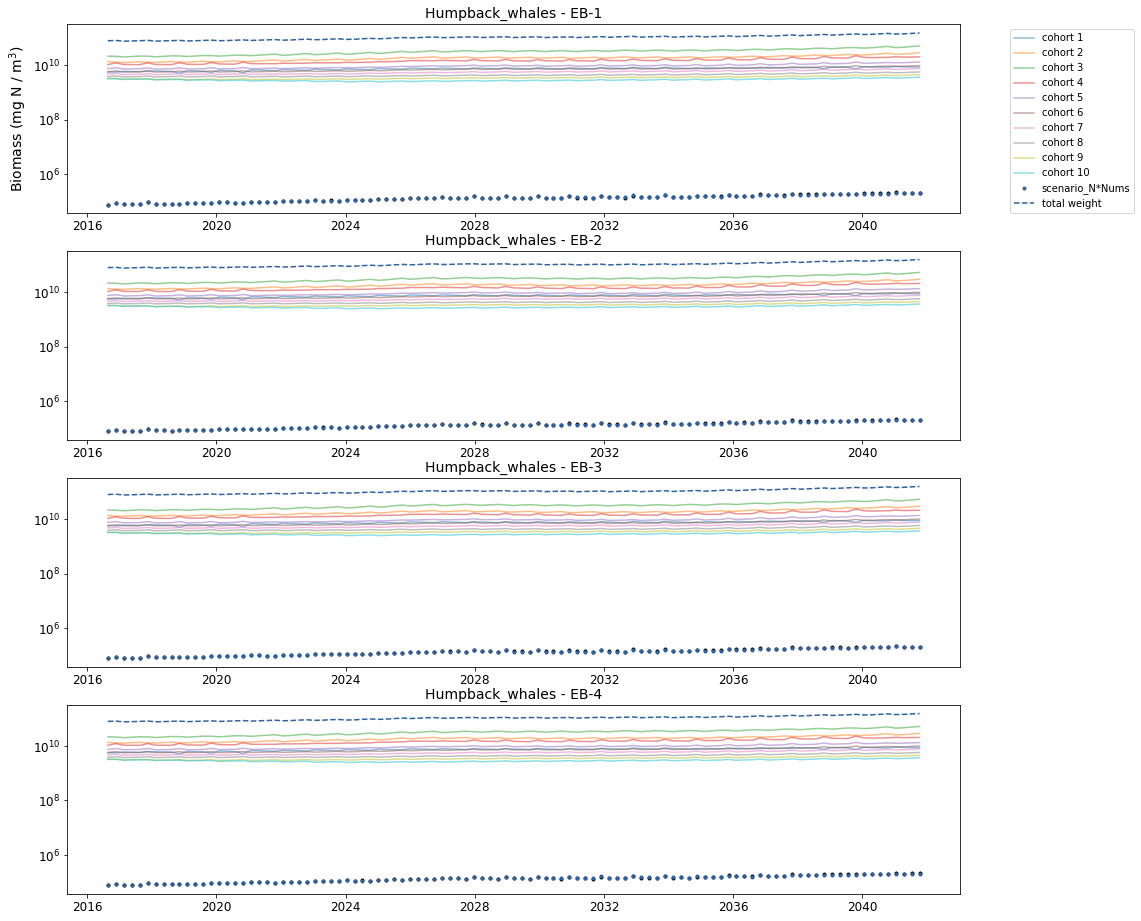

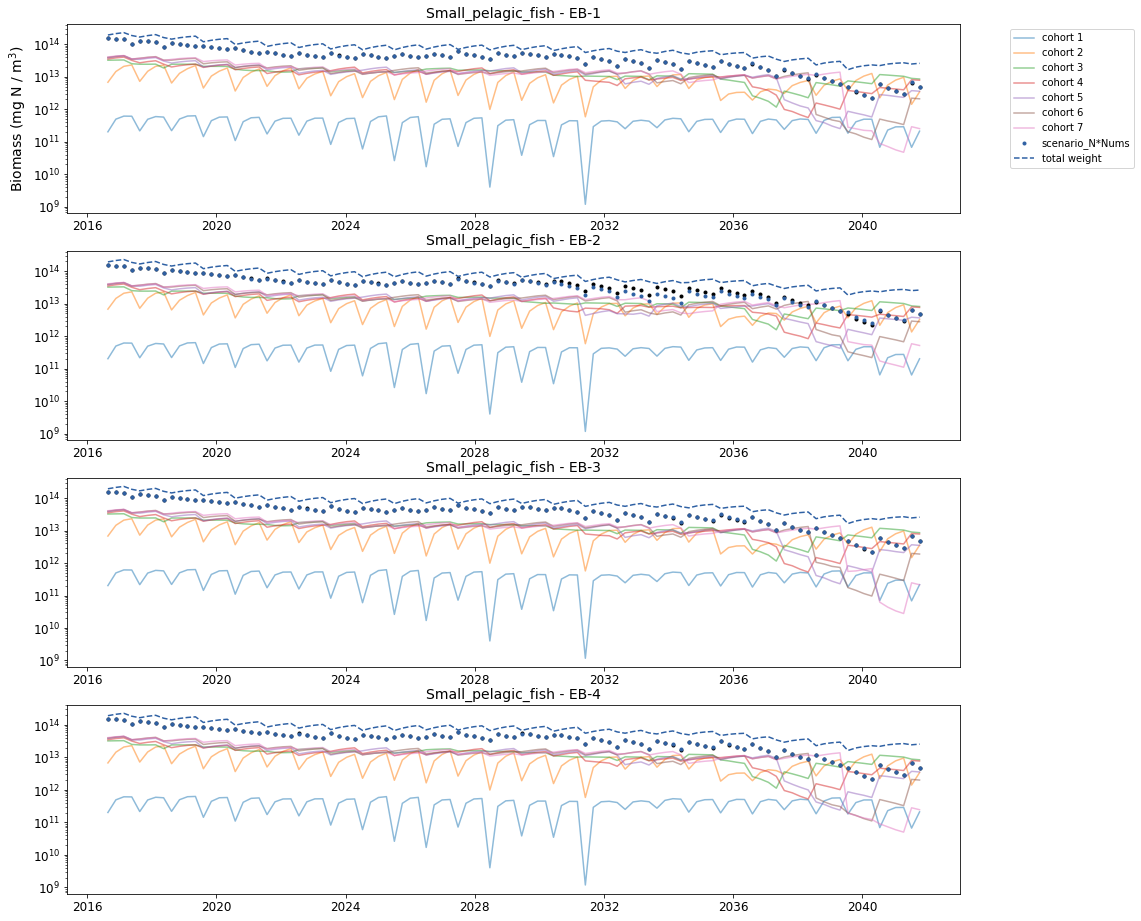

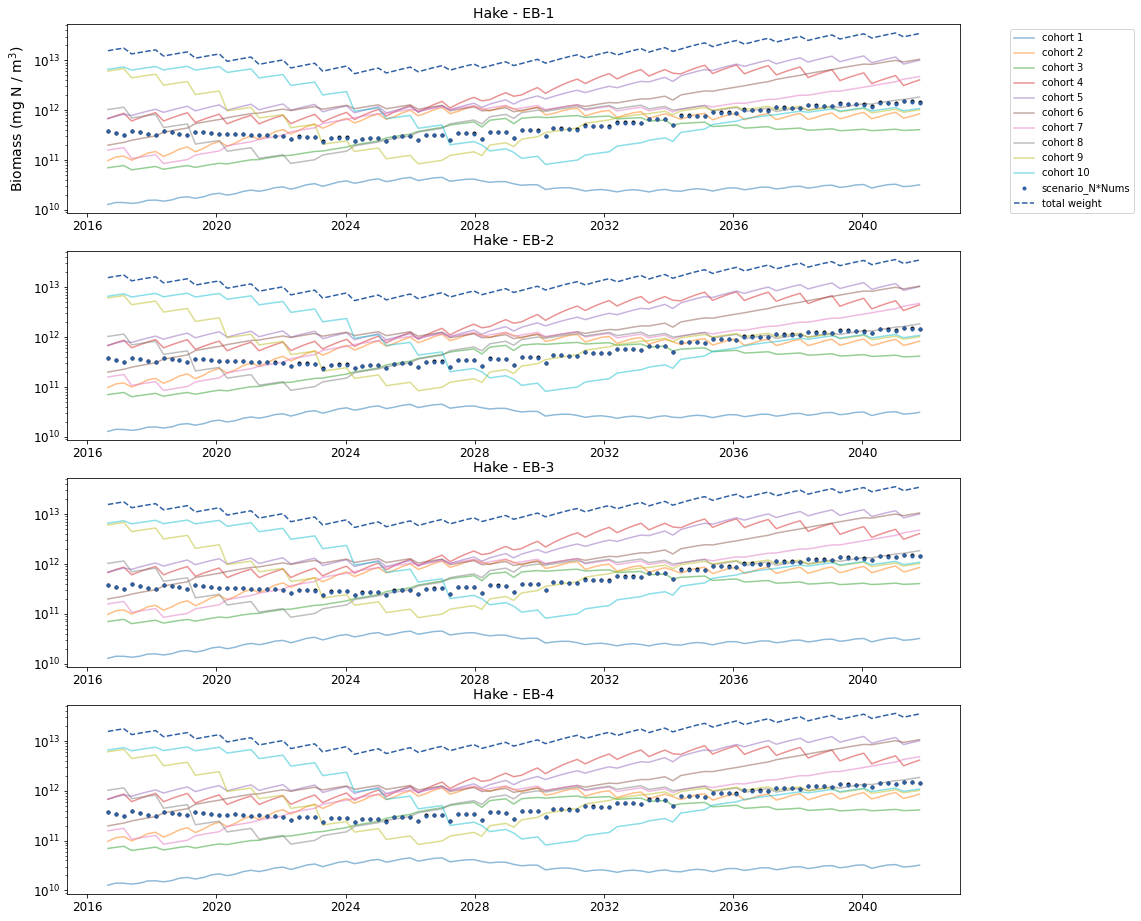

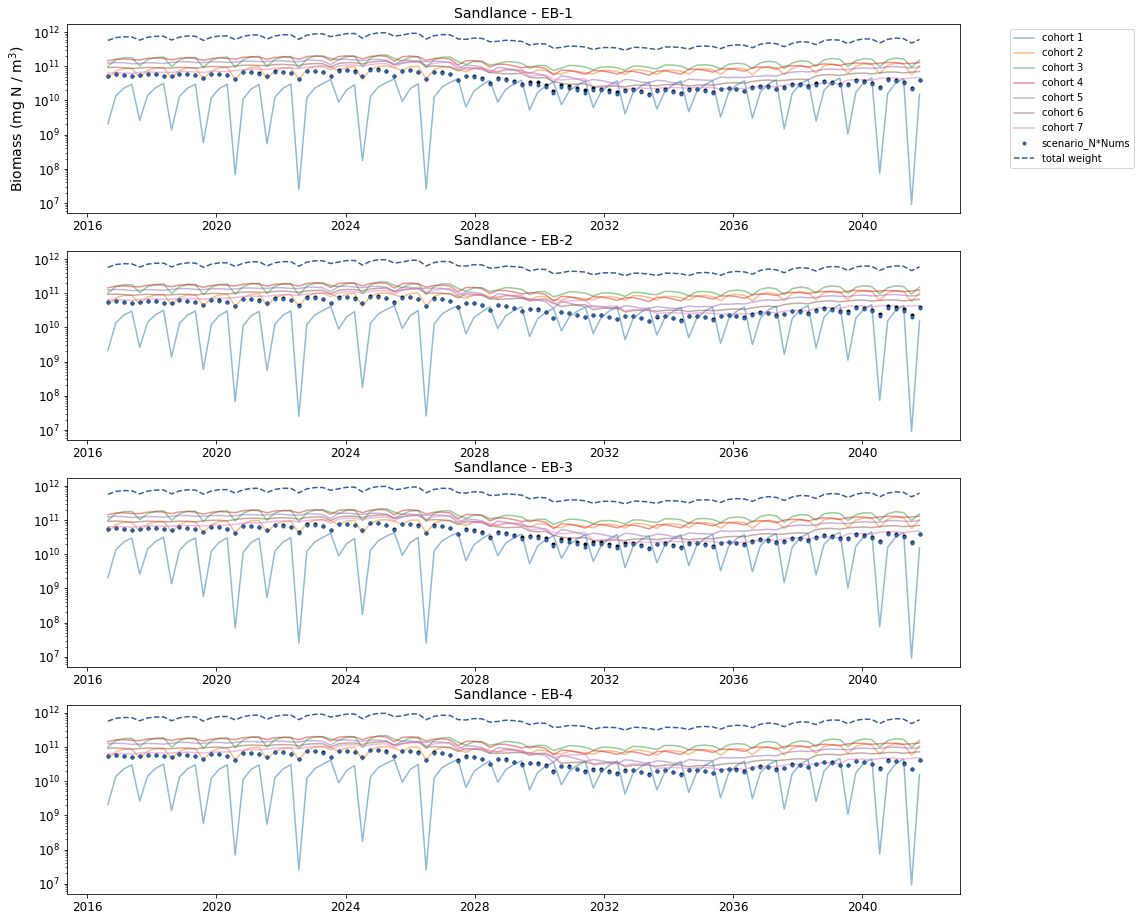

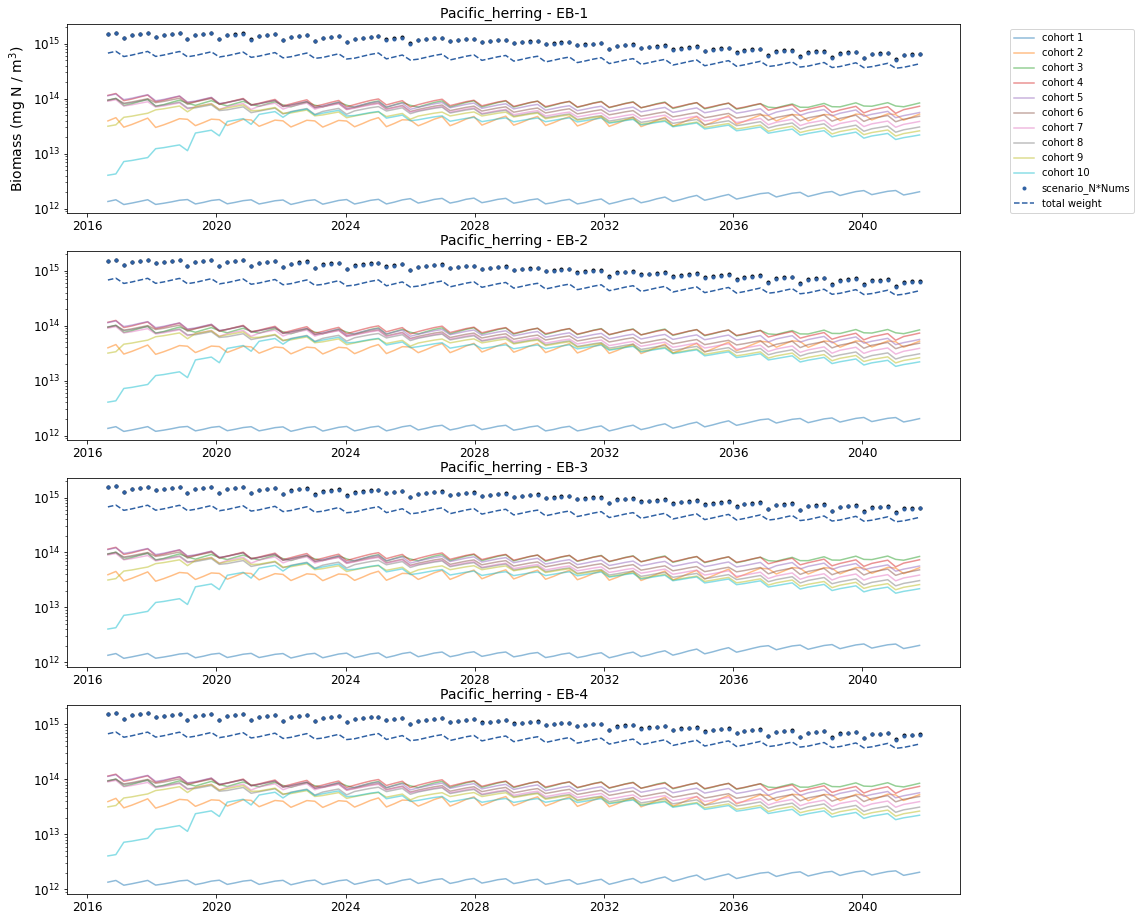

In [20]:
compare_cohort_biomass_totals2(affected_pelagic, boxes=groups.salish_sea)

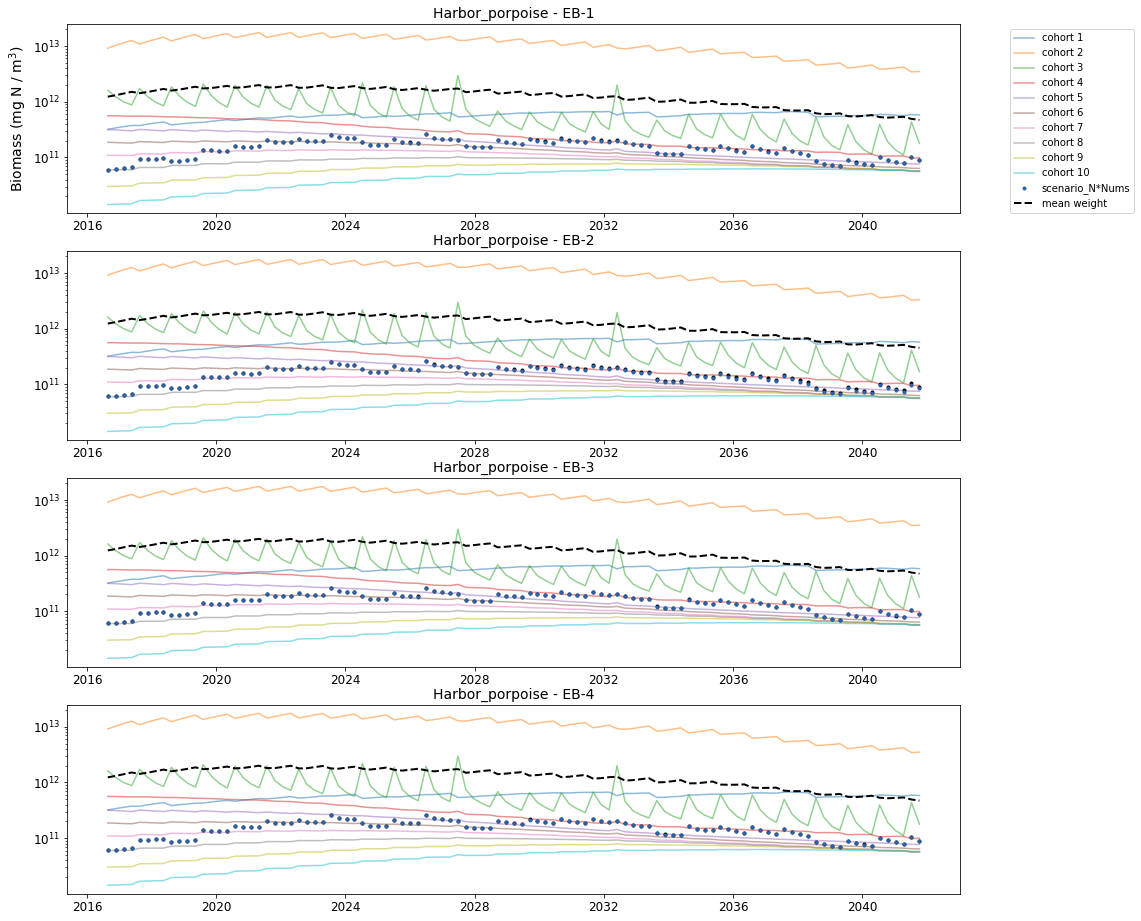

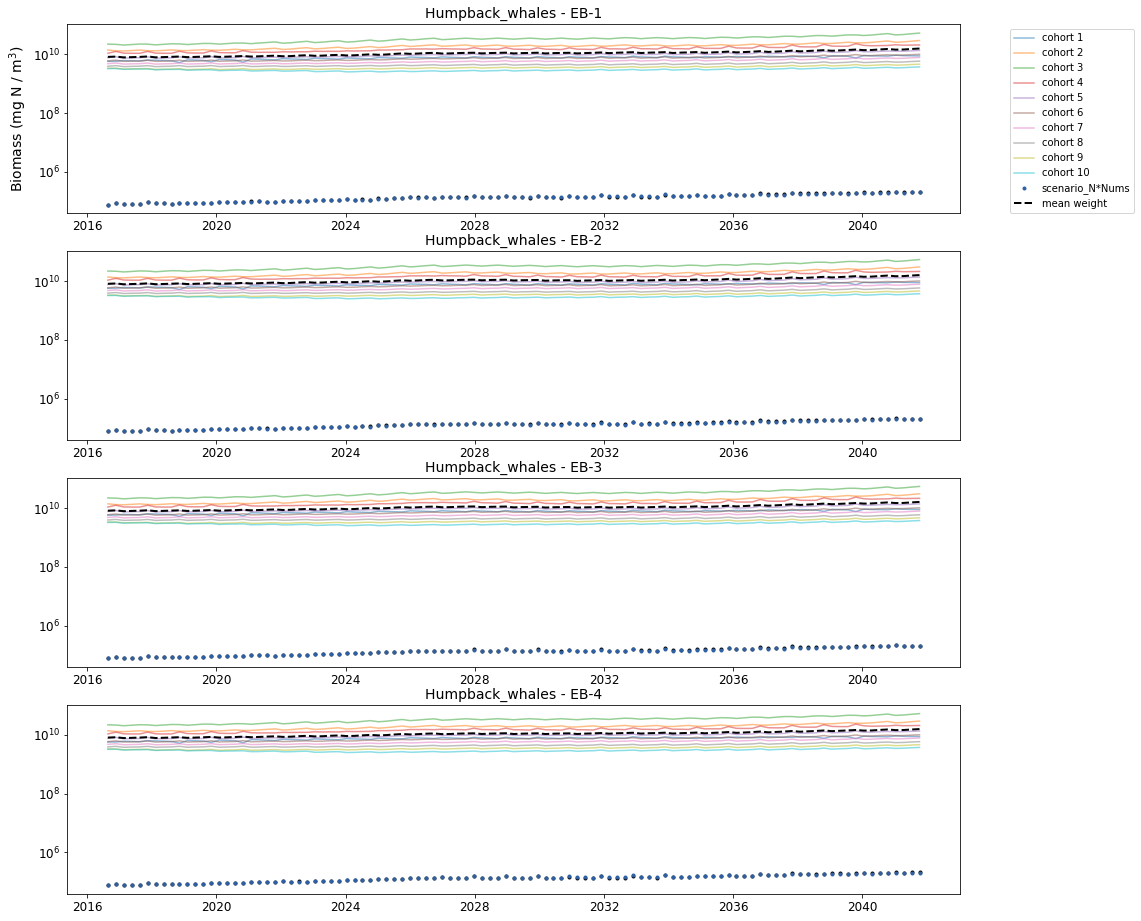

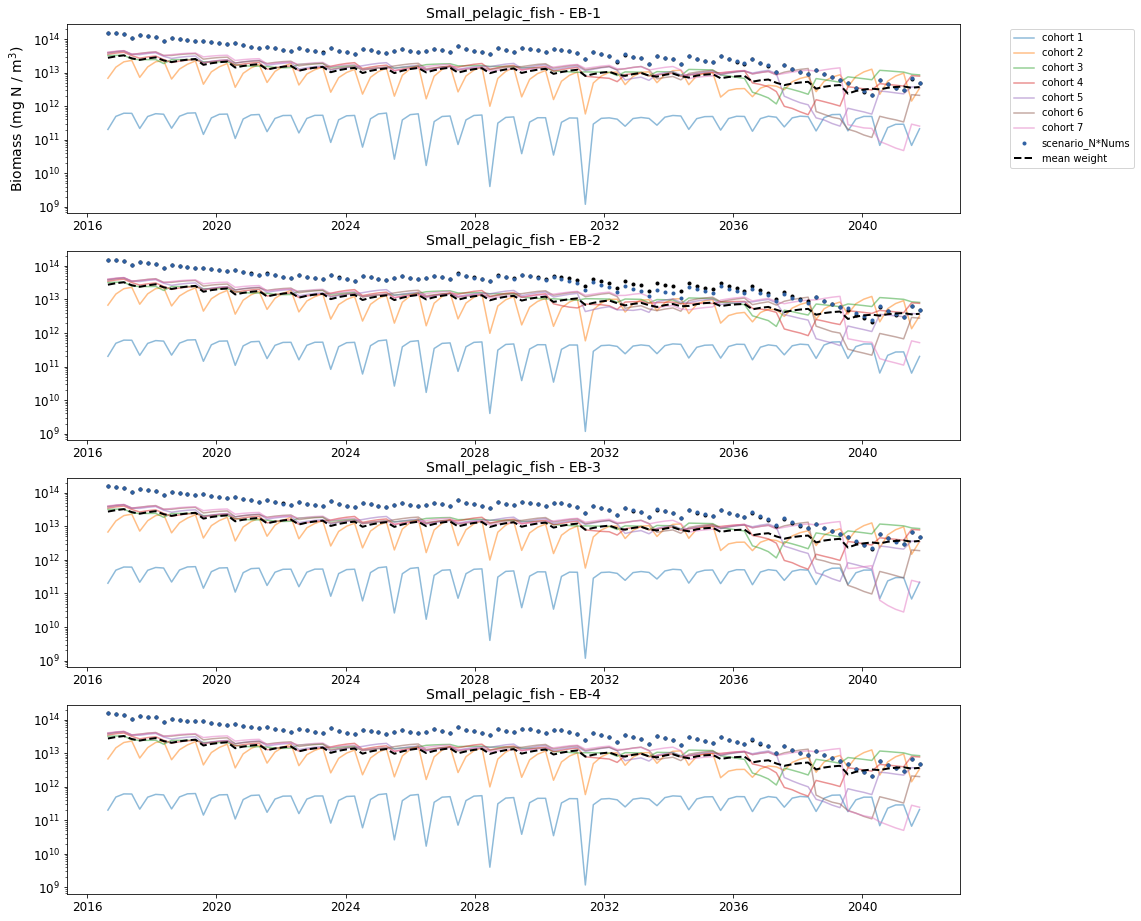

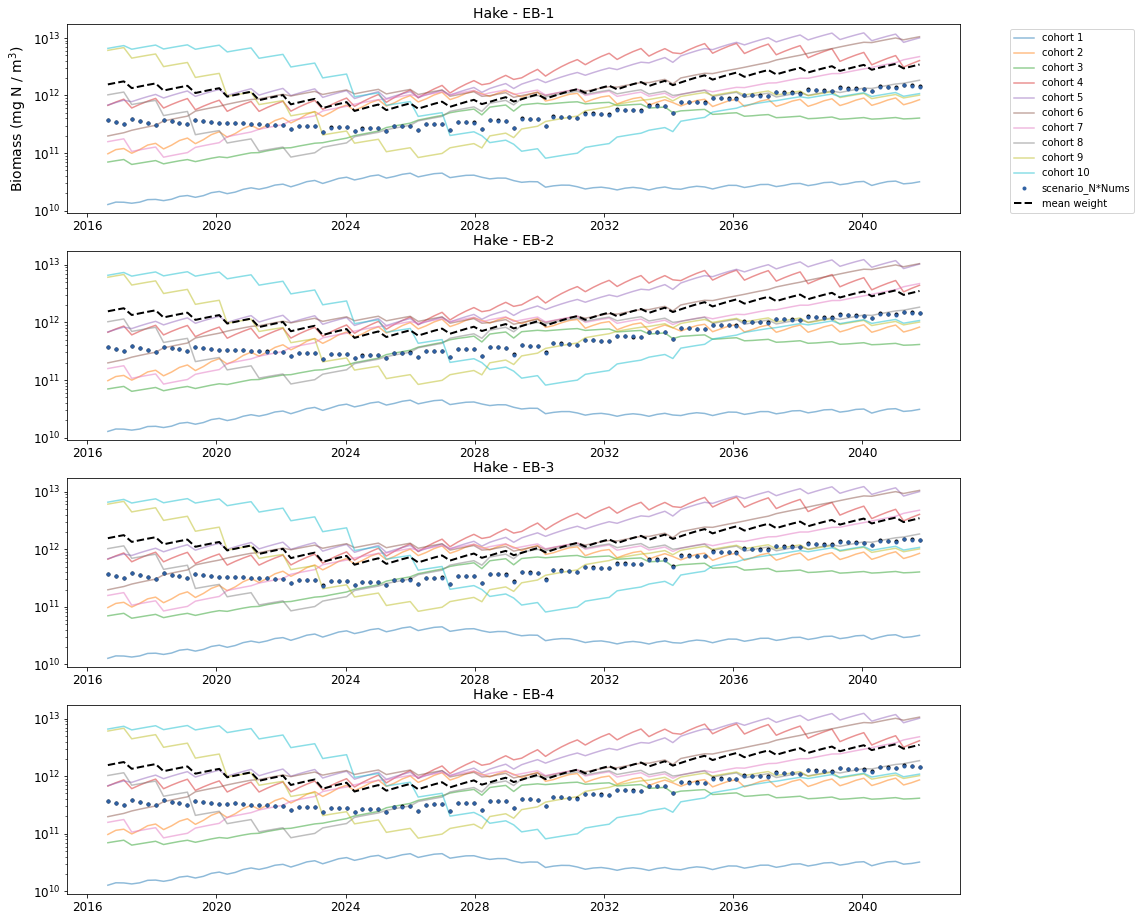

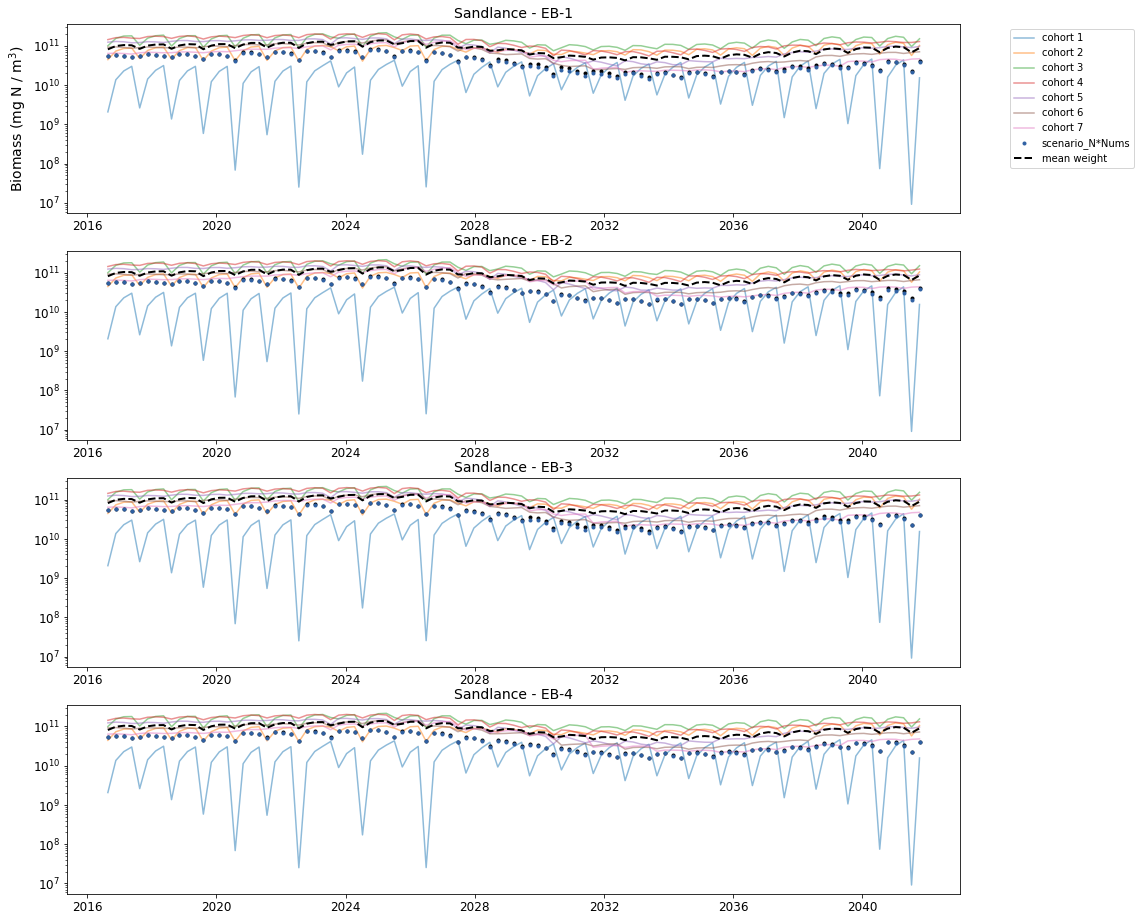

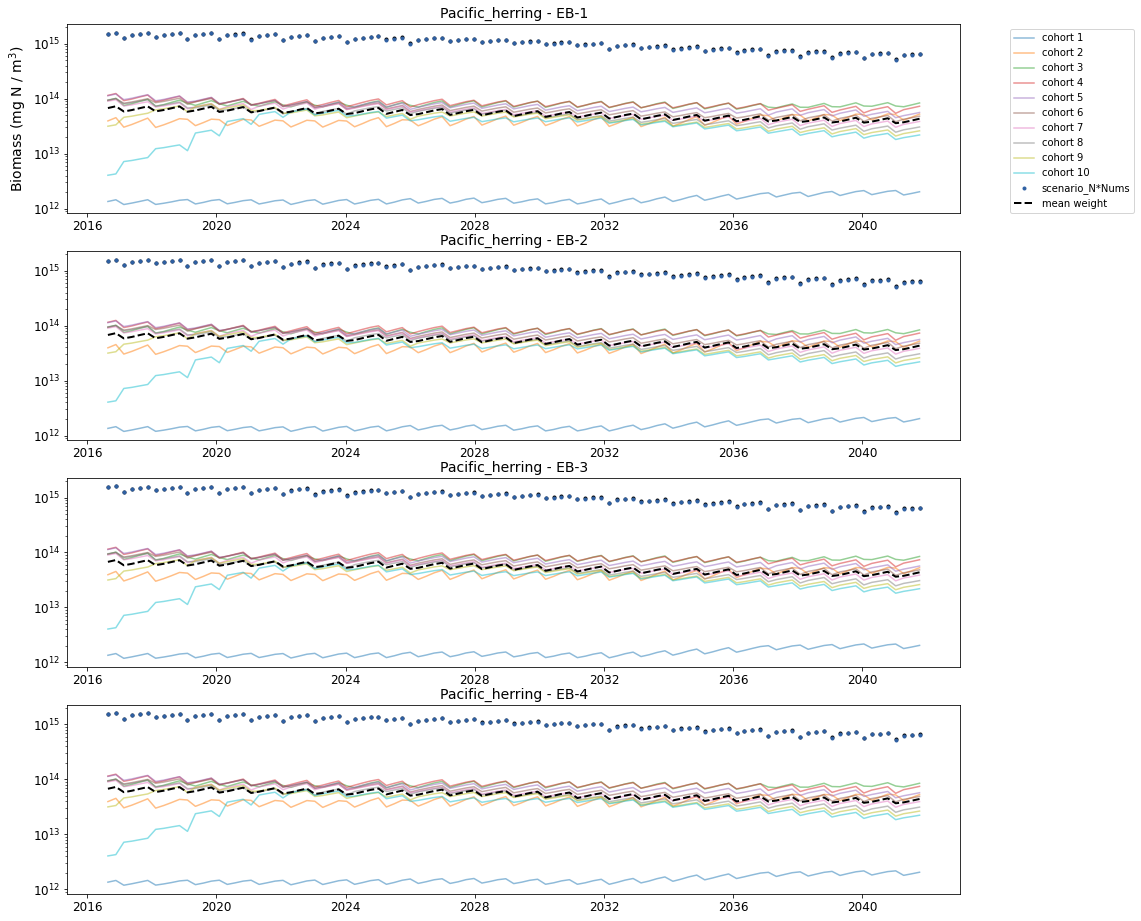

In [21]:
compare_cohort_biomass_mean(affected_pelagic,boxes=groups.salish_sea)

Output *group_N* is always much lower than biomass calculate with _structN, _resN and _Nums. While _N x _Nums leads to a similar magnitude of biomass, it is neither equivalent to the mean across all cohorts nor the sum of all cohorts. Thus _N seems to be a disgnostic feature only, as Beth has said in the past. 

When comparing the change in vertebrate biomass over time, we need to normalize for the fact that larger cohorts have larger biomass. Thus we need to calculate the ratio for each cohort separately, before finding the average change across all cohorts. 

Below, we plot the control and scenario biomass for each cohort, separately. Control biomass is a dashed black line, that only separates from the scenario biomass later in the simulation.

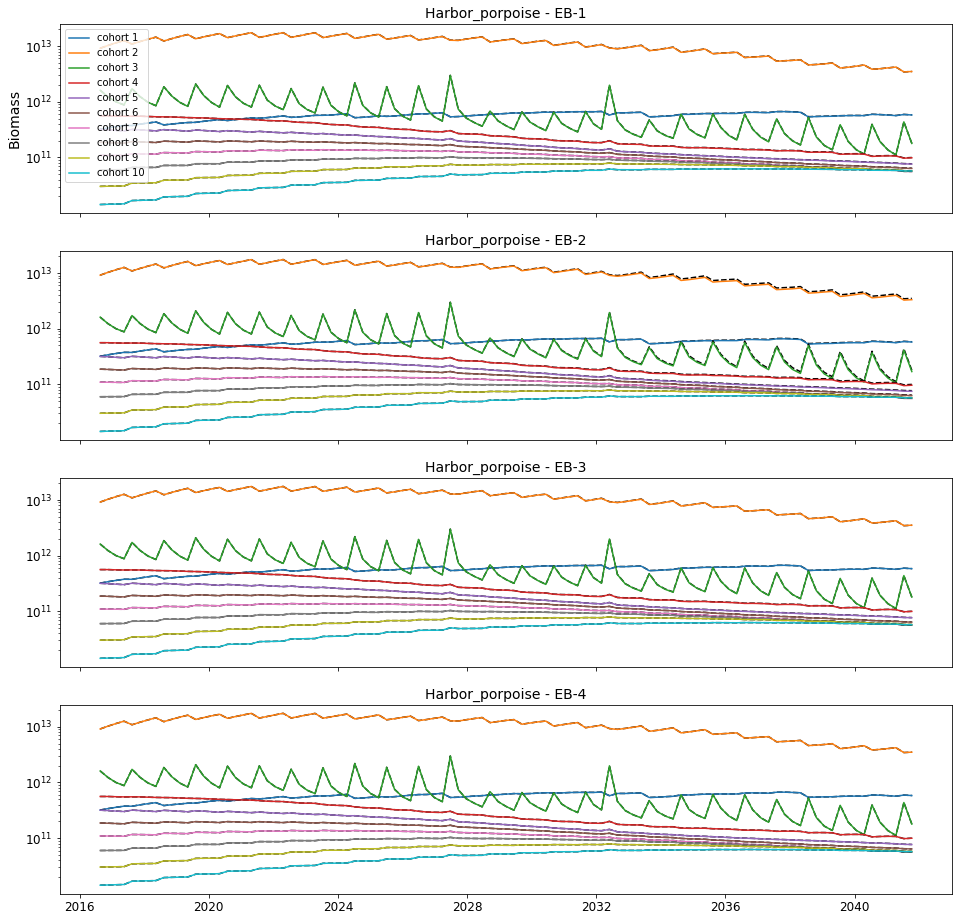

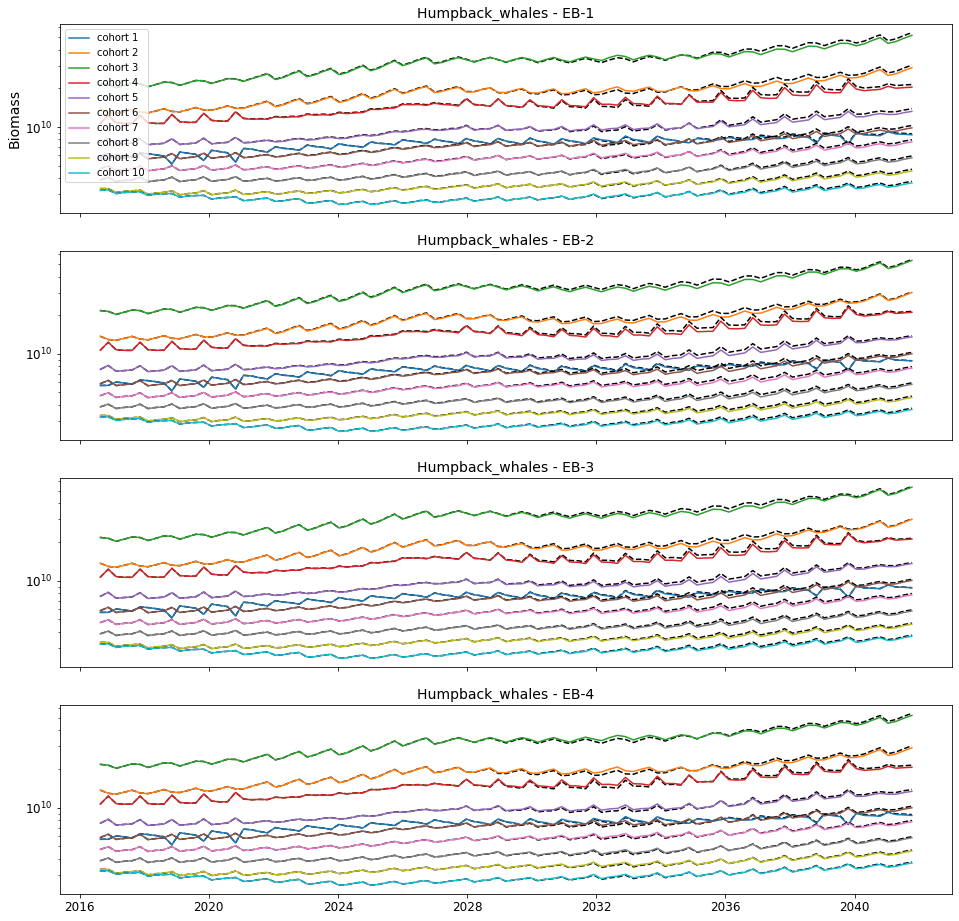

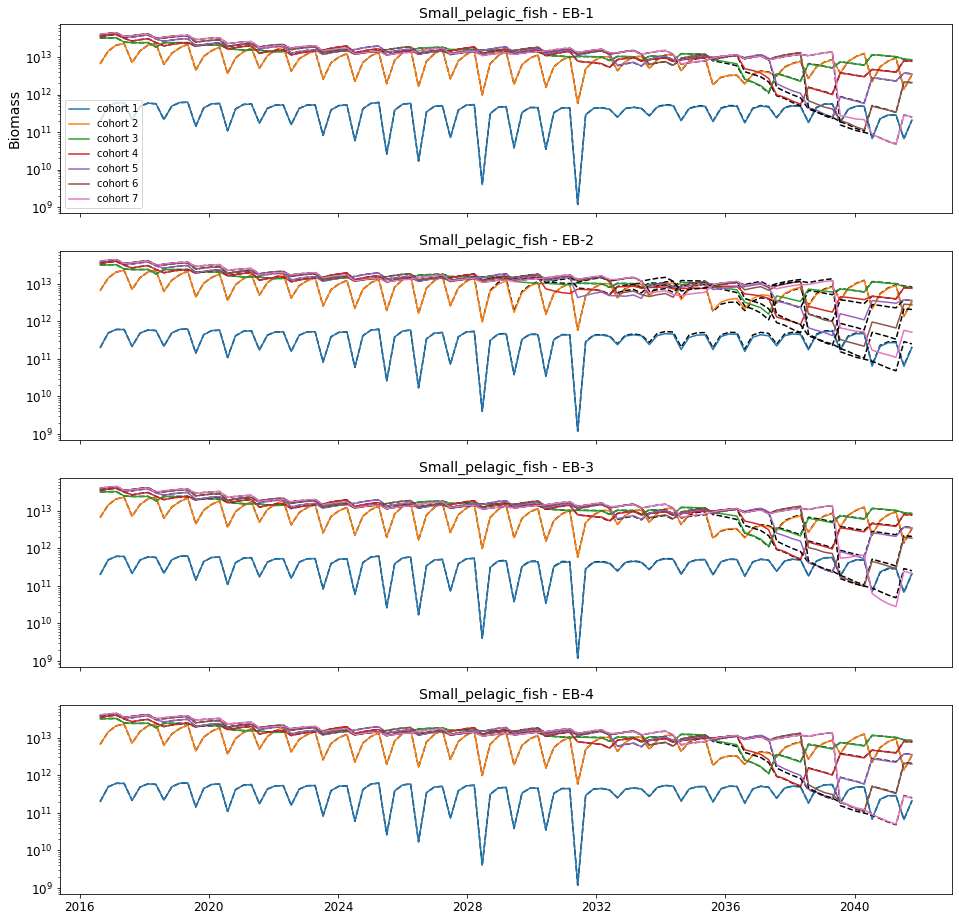

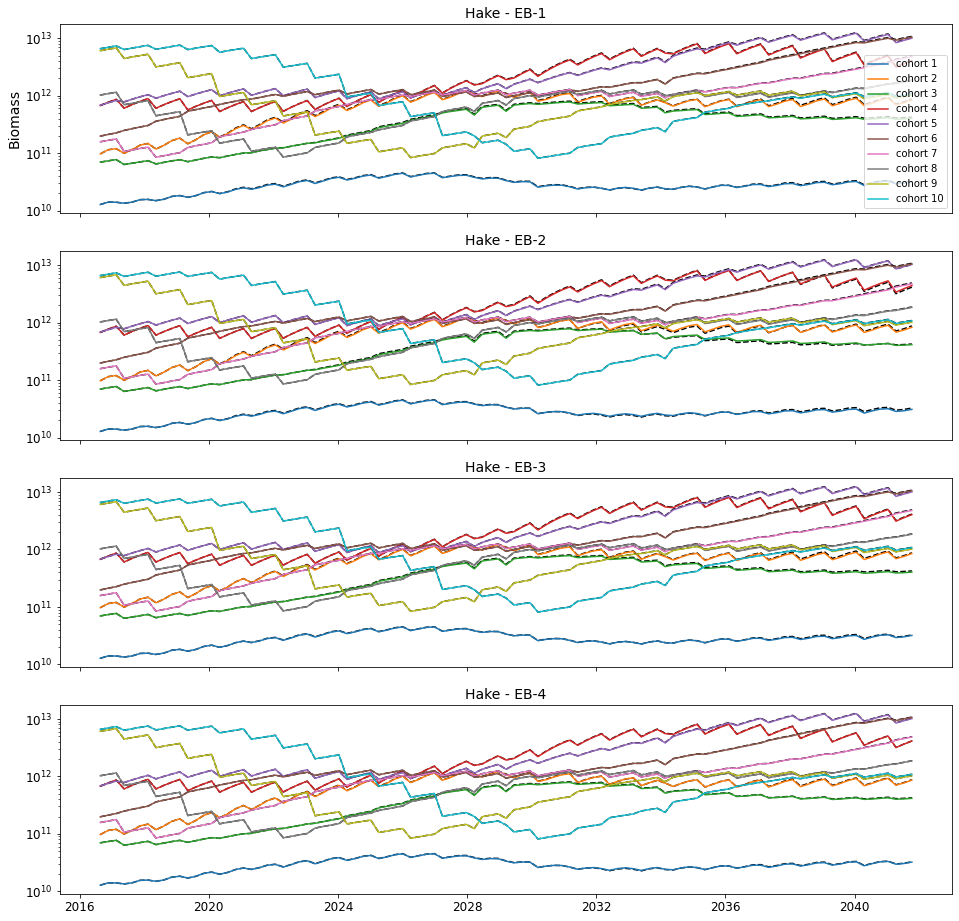

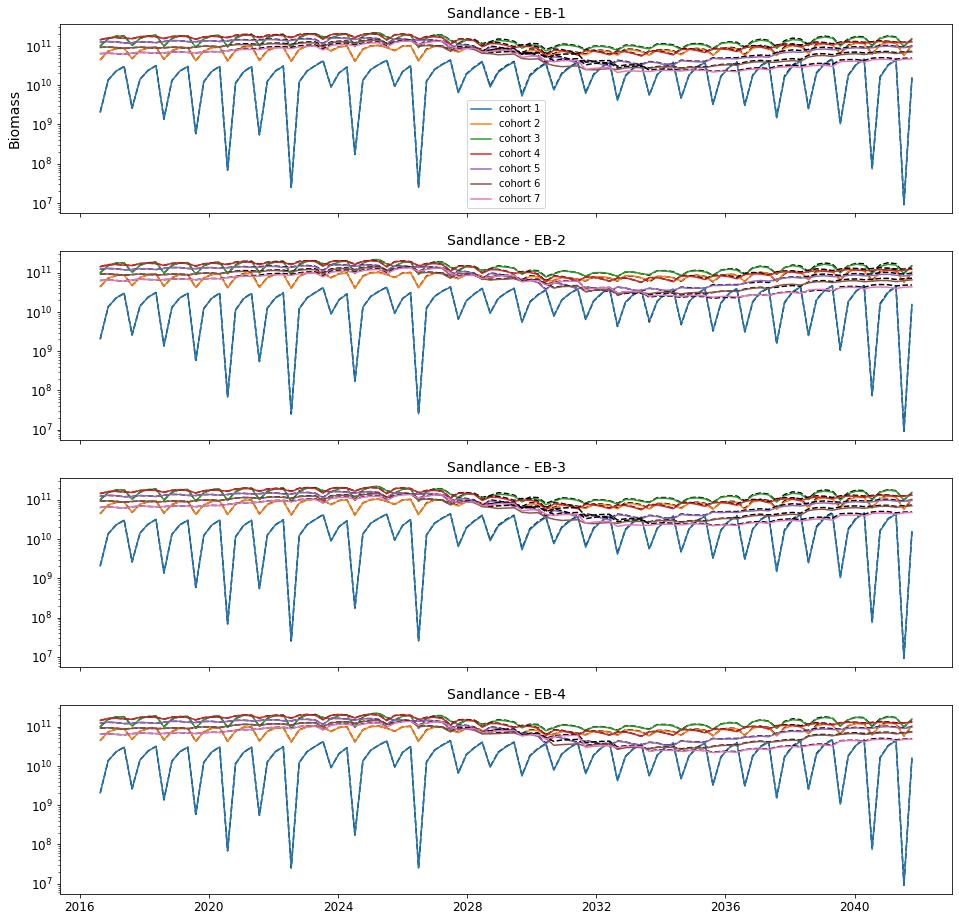

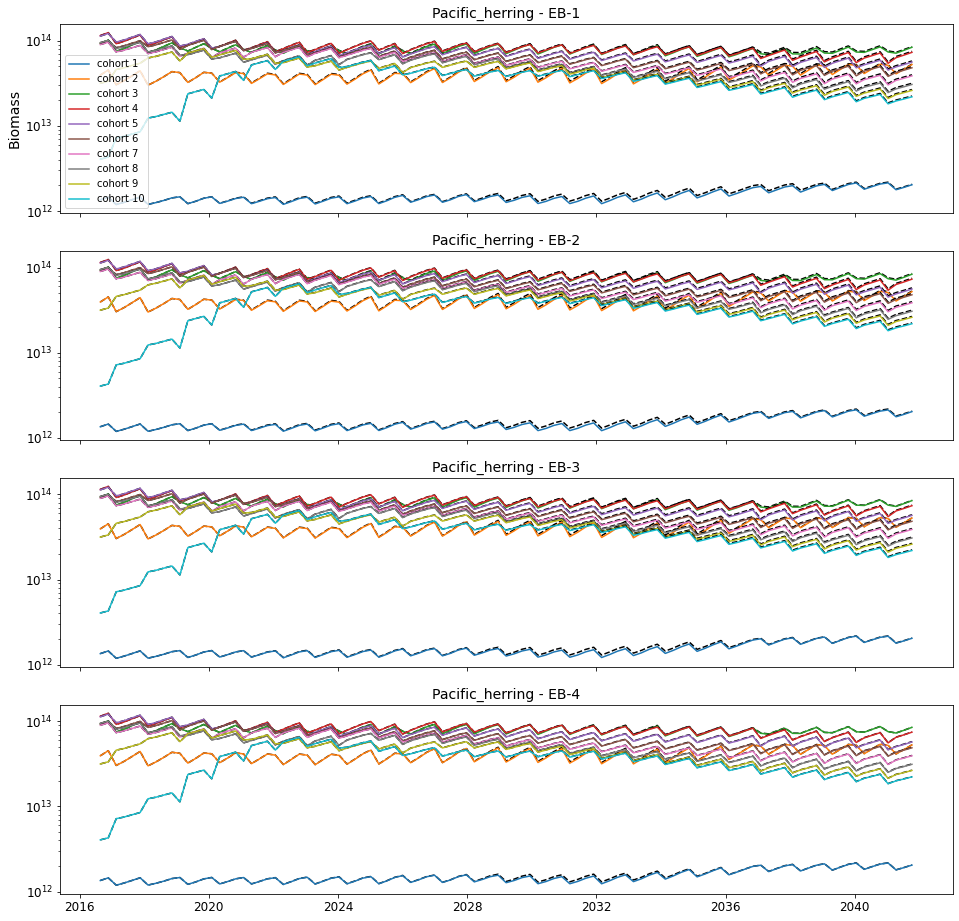

In [36]:
plot_cohort_biomass(affected_pelagic, boxes=groups.salish_sea)

## Box Plots

In [23]:
def progressive_boxplot_pelagic(bio_group, location=groups.salish_sea, x_lim=None):
    all_results = []
    data_labels = ['spill year', '5 years later', '10 years later', '20 years later']

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3]).split(sep='-')[0]
        scenario_name = 'EB-'+nm[2]  # Readable scenario name

        if year == '2019':
            end_days = days2019summer
        elif year == '2020':
            end_days = days2020summer

        for species in bio_group:
            results = []
            for day in end_days:
                p_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:day, location, 0:6], np.nan)
                p_control = np.ma.filled(control.variables[bio_group[species] + '_N'][start:day, location, 0:6], np.nan)
                
                p_oiled = p_oiled.sum(axis=(1, 2)).mean()
                p_control = p_control.sum(axis=(1, 2)).mean()
                
                ratio = (p_oiled / p_control - 1) * 100
                results.append(ratio)

            for label, value in zip(data_labels, results):
                all_results.append({
                    'bio_group': bio_group[species],
                    'sensitivity': groups.sensitivity[species],
                    'sensitivity_negative': -groups.sensitivity[species],
                    'time_label': label,
                    'scenario': scenario_name,
                    'percent_change': value
                })

    # Step 2: Convert to DataFrame
    df = pd.DataFrame(all_results)
    #df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/6a-english-bay-"+str(bio_group[species])+".csv")
    #print(df)
    
    # Step 3: Set up the plot
    time_labels = df['time_label'].unique()
    bio_groups = df['bio_group'].unique()
    scenarios = df['scenario'].unique()
    colors = plt.cm.tab10.colors

    n_rows = len(bio_groups)
    n_cols = len(time_labels)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, n_rows+1), sharey=True)

    if n_cols == 1:
        axes = [axes]  # Make iterable if only 1 subplot

    bar_width = 0.8 / len(scenarios)  # space per group divided by number of scenarios
    y_pos = np.arange(len(bio_groups))

    # Step 4: Plot each time label subplot
    for i, time in enumerate(time_labels):
        ax = axes[i]
        for j, scenario in enumerate(scenarios):
            df_plot = df[(df['time_label'] == time) & (df['scenario'] == scenario)]
            df_plot = df_plot.set_index('bio_group').reindex(bio_groups)  # Ensure consistent order
            offset = (j - len(scenarios)/2) * bar_width + bar_width/2

            ax.barh(y_pos + offset, df_plot['percent_change'], height=bar_width, label=scenario, facecolor=hex_colour, alpha=0.6, edgecolor='black', hatch=hatches[j])
        ax.barh(bio_groups, df_plot['sensitivity'], label=scenario, color='grey', alpha=0.3)
        ax.barh(bio_groups, df_plot['sensitivity_negative'], label=scenario, color='grey', alpha=0.3)
       
        ax.set_title(time, fontsize=15)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(bio_groups, fontsize=15) 
        ax.set_xlim(x_lim)
        ax.set_xlabel("Percent Change", fontsize=13)

    # Step 5: Final layout
    fig.legend(np.append(scenarios,'model threshold'), loc='upper center', ncol=len(scenarios)+1, fontsize=15) 
    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    #axes[0].set_ylabel(bio_groups)
    plt.show()

In [18]:
def progressive_boxplot_vertebrates(bio_group, location=groups.salish_sea, x_lim=None):
    all_results = []
    data_labels = ['spill year', '5 years later', '10 years later', '20 years later']

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3]).split(sep='-')[0]
        scenario_name = 'EB-'+nm[2]  # Readable scenario name

        if year == '2019':
            end_days = days2019summer
        elif year == '2020':
            end_days = days2020summer

        for species in bio_group:
            results = []
            numCohorts = groups.cohorts[bio_group[species]]
            for day in end_days:

                sum_ratio = 0

                for cohort in range (1, numCohorts+1):

                    new_species = bio_group[species] + str(cohort)
                
                    o_numbers_tbl = np.ma.filled(scenario.variables[new_species + '_Nums'][start:day, location, 0:6], np.nan)
                    o_structuralN_tbl = np.ma.filled(scenario.variables[new_species +'_StructN'][start:day, location, 0:6], np.nan)
                    o_reservedN_tbl = np.ma.filled(scenario.variables[new_species +'_ResN'][start:day, location, 0:6], np.nan)

                    c_numbers_tbl = np.ma.filled(control.variables[new_species + '_Nums'][start:day, location, 0:6], np.nan)
                    c_structuralN_tbl = np.ma.filled(control.variables[new_species +'_StructN'][start:day, location, 0:6], np.nan)
                    c_reservedN_tbl = np.ma.filled(control.variables[new_species +'_ResN'][start:day, location, 0:6], np.nan)

                    o_weightatage_tbl = (o_structuralN_tbl + o_reservedN_tbl) * o_numbers_tbl 
                    o_weightatage = o_weightatage_tbl.sum(axis=(1,2)).mean()

                    c_weightatage_tbl = (c_structuralN_tbl + c_reservedN_tbl) * c_numbers_tbl 
                    c_weightatage = c_weightatage_tbl.sum(axis=(1,2)).mean()

                    #difference = o_weightatage_tb.sum(axis=1) - c_weightatage_tb.sum(axis=1) 
                    ratio = (o_weightatage / c_weightatage - 1) * 100
                    #print(ratio)
                    sum_ratio = sum_ratio + ratio

                results.append(sum_ratio/numCohorts)

            for label, value in zip(data_labels, results):
                all_results.append({
                    'bio_group': bio_group[species],
                    'sensitivity': groups.sensitivity[species],
                    'sensitivity_negative': -groups.sensitivity[species],
                    'time_label': label,
                    'scenario': scenario_name,
                    'percent_change': value
                })

    df = pd.DataFrame(all_results)
    #df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/6a-english-bay-"+str(bio_group[species])+".csv")
    #print(df)
    
    time_labels = df['time_label'].unique()
    bio_groups = df['bio_group'].unique()
    scenarios = df['scenario'].unique()
    colors = plt.cm.tab10.colors

    n_rows = len(bio_groups)
    n_cols = len(time_labels)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, n_rows+1), sharey=True)

    if n_cols == 1:
        axes = [axes]  # Make iterable if only 1 subplot

    bar_width = 0.8 / len(scenarios)  # space per group divided by number of scenarios
    y_pos = np.arange(len(bio_groups))

    for i, time in enumerate(time_labels):
        ax = axes[i]
        for j, scenario in enumerate(scenarios):
            df_plot = df[(df['time_label'] == time) & (df['scenario'] == scenario)]
            df_plot = df_plot.set_index('bio_group').reindex(bio_groups)  # Ensure consistent order
            offset = (j - len(scenarios)/2) * bar_width + bar_width/2

            ax.barh(y_pos + offset, df_plot['percent_change'], height=bar_width, label=scenario, facecolor=hex_colour, alpha=0.6, edgecolor='black', hatch=hatches[j])
        ax.barh(bio_groups, df_plot['sensitivity'], label=scenario, color='grey', alpha=0.3)
        ax.barh(bio_groups, df_plot['sensitivity_negative'], label=scenario, color='grey', alpha=0.3)
       
        ax.set_title(time, fontsize=15)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(bio_groups, fontsize=15) 
        ax.set_xlim(x_lim)
        ax.set_xlabel("Percent Change", fontsize=13)

    fig.legend(np.append(scenarios,'model threshold'), loc='upper center', ncol=len(scenarios)+1, fontsize=15) 
    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    #axes[0].set_ylabel(bio_groups)
    plt.show()

In [15]:
def progressive_boxplot_numbers(bio_group, location=groups.salish_sea, x_lim=None):
    all_results = []
    data_labels = ['spill year', '5 years later', '10 years later', '20 years later']

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3]).split(sep='-')[0]
        scenario_name = 'EB-'+nm[2]  # Readable scenario name

        if year == '2019':
            end_days = days2019summer
        elif year == '2020':
            end_days = days2020summer

        for species in bio_group:
            results = []
            numCohorts = groups.cohorts[bio_group[species]]
            for day in end_days:
                sum_ratio = 0

                for cohort in range (1, numCohorts+1):

                    new_species = bio_group[species] + str(cohort)
                    
                
                    o_numbers_tbl = np.ma.filled(scenario.variables[new_species + '_Nums'][start:day, location, 0:6], np.nan)
                    c_numbers_tbl = np.ma.filled(control.variables[new_species + '_Nums'][start:day, location, 0:6], np.nan)

                    o_numbers = o_numbers_tbl.sum(axis=(1,2)).mean()
                    c_numbers = c_numbers_tbl.sum(axis=(1,2)).mean()

                    #difference = o_weightatage_tb.sum(axis=1) - c_weightatage_tb.sum(axis=1) 
                    ratio = (o_numbers / c_numbers - 1) * 100
                    #print(ratio)
                    sum_ratio = sum_ratio + ratio

                results.append(sum_ratio/numCohorts)

            for label, value in zip(data_labels, results):
                all_results.append({
                    'bio_group': bio_group[species],
                    'sensitivity': groups.sensitivity[species],
                    'sensitivity_negative': -groups.sensitivity[species],
                    'time_label': label,
                    'scenario': scenario_name,
                    'percent_change': value
                })

    df = pd.DataFrame(all_results)
    #df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/6a-english-bay-"+str(bio_group[species])+".csv")
    #print(df)
    
    time_labels = df['time_label'].unique()
    bio_groups = df['bio_group'].unique()
    scenarios = df['scenario'].unique()
    colors = plt.cm.tab10.colors

    n_rows = len(bio_groups)
    n_cols = len(time_labels)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, n_rows+1), sharey=True)

    if n_cols == 1:
        axes = [axes]  # Make iterable if only 1 subplot

    bar_width = 0.8 / len(scenarios)  # space per group divided by number of scenarios
    y_pos = np.arange(len(bio_groups))

    for i, time in enumerate(time_labels):
        ax = axes[i]
        for j, scenario in enumerate(scenarios):
            df_plot = df[(df['time_label'] == time) & (df['scenario'] == scenario)]
            df_plot = df_plot.set_index('bio_group').reindex(bio_groups)  # Ensure consistent order
            offset = (j - len(scenarios)/2) * bar_width + bar_width/2

            ax.barh(y_pos + offset, df_plot['percent_change'], height=bar_width, label=scenario, facecolor=hex_colour, alpha=0.6, edgecolor='black', hatch=hatches[j])
        ax.barh(bio_groups, df_plot['sensitivity'], label=scenario, color='grey', alpha=0.3)
        ax.barh(bio_groups, df_plot['sensitivity_negative'], label=scenario, color='grey', alpha=0.3)
       
        ax.set_title(time, fontsize=15)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(bio_groups, fontsize=15) 
        ax.set_xlim(x_lim)
        ax.set_xlabel("Percent Change", fontsize=13)

    fig.legend(np.append(scenarios,'model threshold'), loc='upper center', ncol=len(scenarios)+1, fontsize=15) 
    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    #axes[0].set_ylabel(bio_groups)
    plt.show()

In [43]:
def progressive_boxplot_cohort(bio_group, cohort, location=groups.salish_sea, x_lim=None):
    all_results = []
    data_labels = ['spill year', '5 years later', '10 years later', '20 years later']

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3]).split(sep='-')[0]
        scenario_name = 'EB-'+nm[2]  # Readable scenario name

        if year == '2019':
            end_days = days2019summer
        elif year == '2020':
            end_days = days2020summer

        for species in bio_group:
            results = []
            numCohorts = groups.cohorts[bio_group[species]]
            for day in end_days:

                new_species = bio_group[species] + str(cohort)
            
                o_numbers_tbl = np.ma.filled(scenario.variables[new_species + '_Nums'][start:day, location, 0:6], np.nan)
                o_structuralN_tbl = np.ma.filled(scenario.variables[new_species +'_StructN'][start:day, location, 0:6], np.nan)
                o_reservedN_tbl = np.ma.filled(scenario.variables[new_species +'_ResN'][start:day, location, 0:6], np.nan)

                c_numbers_tbl = np.ma.filled(control.variables[new_species + '_Nums'][start:day, location, 0:6], np.nan)
                c_structuralN_tbl = np.ma.filled(control.variables[new_species +'_StructN'][start:day, location, 0:6], np.nan)
                c_reservedN_tbl = np.ma.filled(control.variables[new_species +'_ResN'][start:day, location, 0:6], np.nan)

                o_weightatage_tbl = (o_structuralN_tbl + o_reservedN_tbl) * o_numbers_tbl 
                o_weightatage = o_weightatage_tbl.sum(axis=(1,2)).mean()

                c_weightatage_tbl = (c_structuralN_tbl + c_reservedN_tbl) * c_numbers_tbl 
                c_weightatage = c_weightatage_tbl.sum(axis=(1,2)).mean()

                #difference = o_weightatage_tb.sum(axis=1) - c_weightatage_tb.sum(axis=1) 
                ratio = (o_weightatage / c_weightatage - 1) * 100

                results.append(ratio)

            for label, value in zip(data_labels, results):
                all_results.append({
                    'bio_group': bio_group[species],
                    'sensitivity': groups.sensitivity[species],
                    'sensitivity_negative': -groups.sensitivity[species],
                    'time_label': label,
                    'scenario': scenario_name,
                    'percent_change': value
                })

    df = pd.DataFrame(all_results)
    #df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/6a-english-bay-"+str(bio_group[species])+".csv")
    #print(df)
    
    time_labels = df['time_label'].unique()
    bio_groups = df['bio_group'].unique()
    scenarios = df['scenario'].unique()
    colors = plt.cm.tab10.colors

    n_rows = len(bio_groups)
    n_cols = len(time_labels)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, n_rows+1), sharey=True)

    if n_cols == 1:
        axes = [axes]  # Make iterable if only 1 subplot

    bar_width = 0.8 / len(scenarios)  # space per group divided by number of scenarios
    y_pos = np.arange(len(bio_groups))

    for i, time in enumerate(time_labels):
        ax = axes[i]
        for j, scenario in enumerate(scenarios):
            df_plot = df[(df['time_label'] == time) & (df['scenario'] == scenario)]
            df_plot = df_plot.set_index('bio_group').reindex(bio_groups)  # Ensure consistent order
            offset = (j - len(scenarios)/2) * bar_width + bar_width/2

            ax.barh(y_pos + offset, df_plot['percent_change'], height=bar_width, label=scenario, facecolor=hex_colour, alpha=0.6, edgecolor='black', hatch=hatches[j])
        ax.barh(bio_groups, df_plot['sensitivity'], label=scenario, color='grey', alpha=0.3)
        ax.barh(bio_groups, df_plot['sensitivity_negative'], label=scenario, color='grey', alpha=0.3)
       
        ax.set_title(time, fontsize=15)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(bio_groups, fontsize=15) 
        ax.set_xlim(x_lim)
        ax.set_xlabel("Percent Change", fontsize=13)

    fig.legend(np.append(scenarios,'model threshold'), loc='upper center', ncol=len(scenarios)+1, fontsize=15) 
    fig.title('Cohort '+str(cohort))
    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    #axes[0].set_ylabel(bio_groups)
    plt.show()

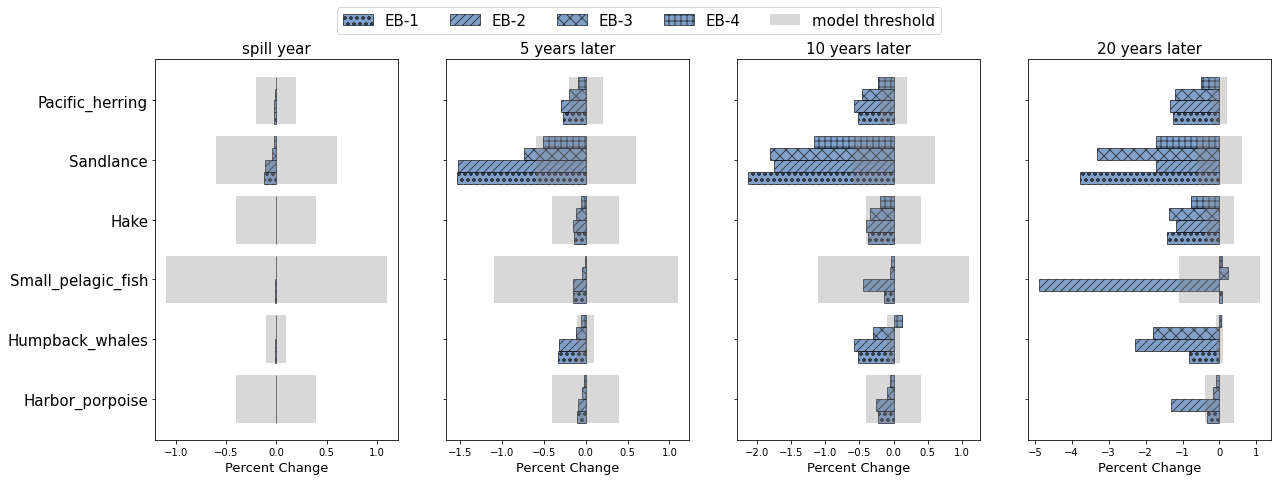

In [26]:
progressive_boxplot_pelagic(affected_pelagic)

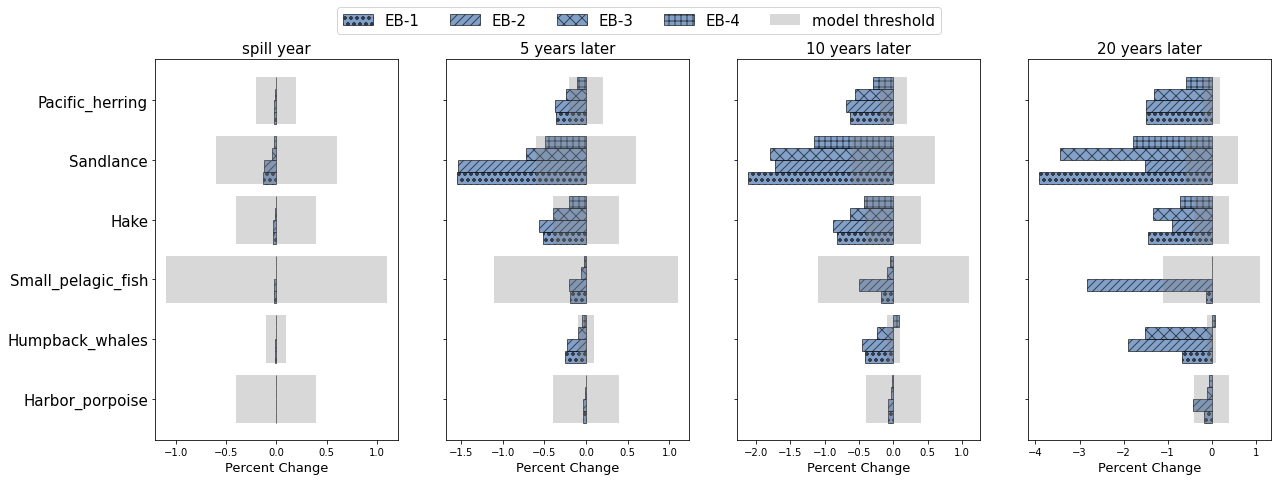

In [45]:
progressive_boxplot_vertebrates(affected_pelagic)

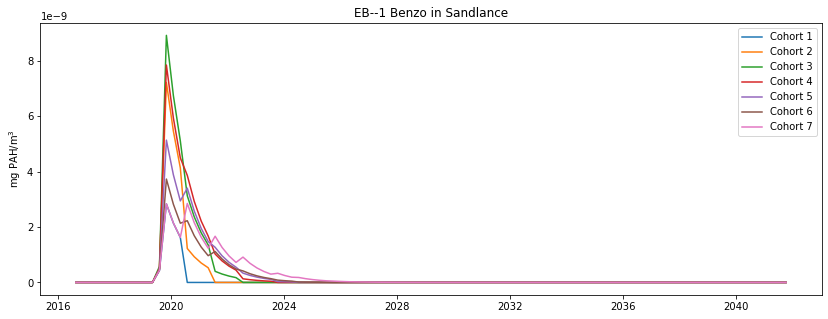

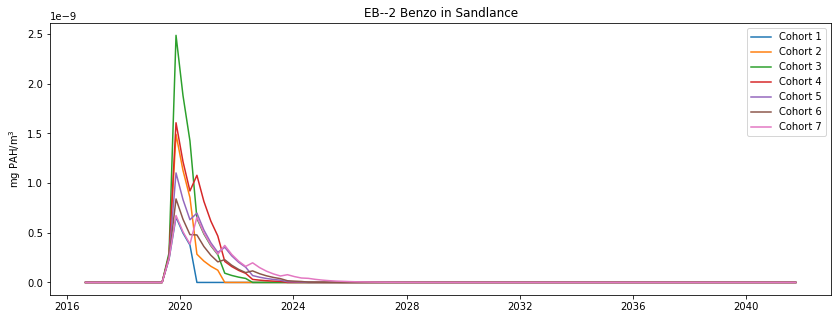

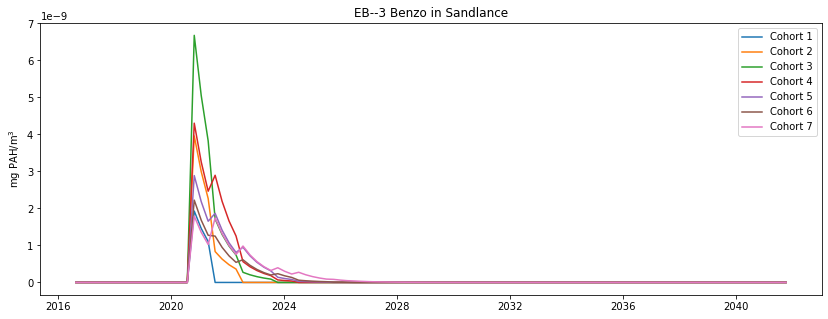

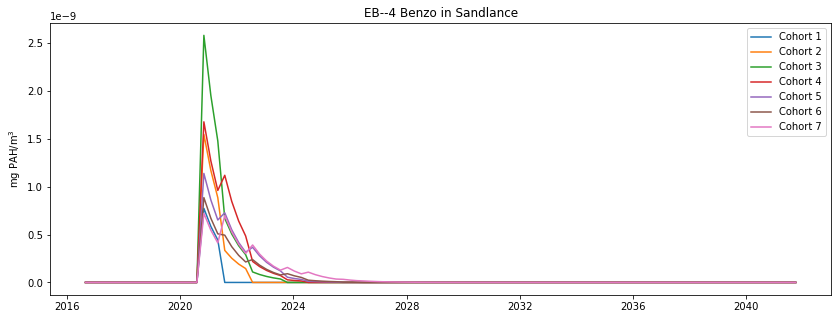

In [23]:
plot_vertebrate_pah('Sandlance','Benzo') 

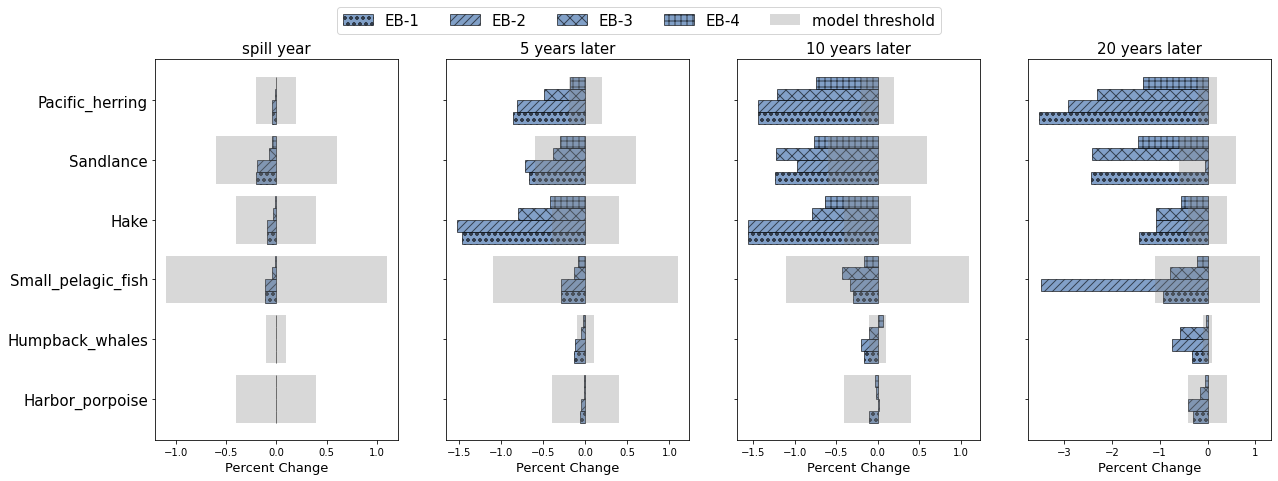

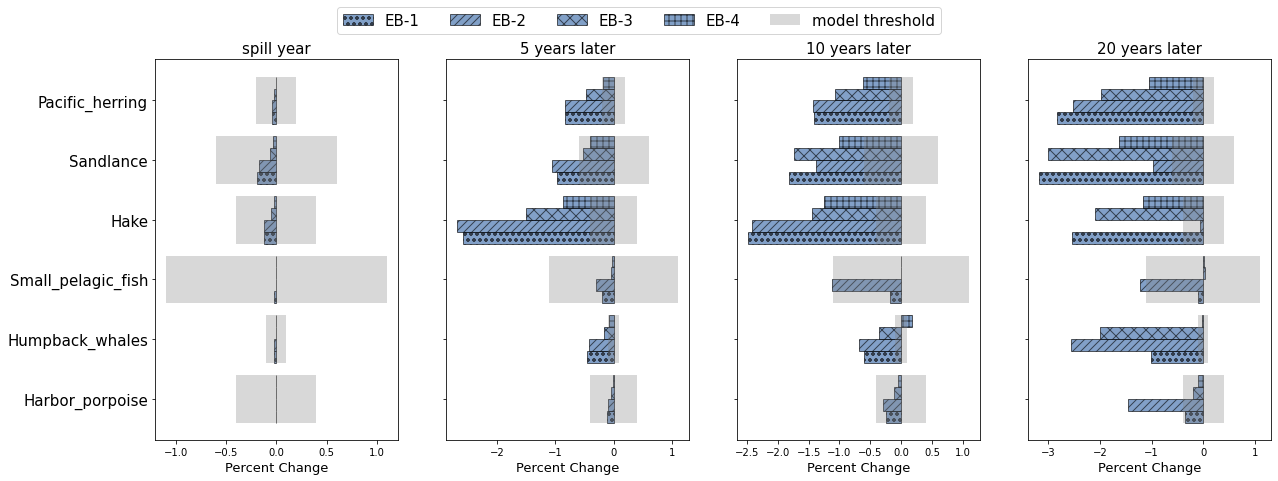

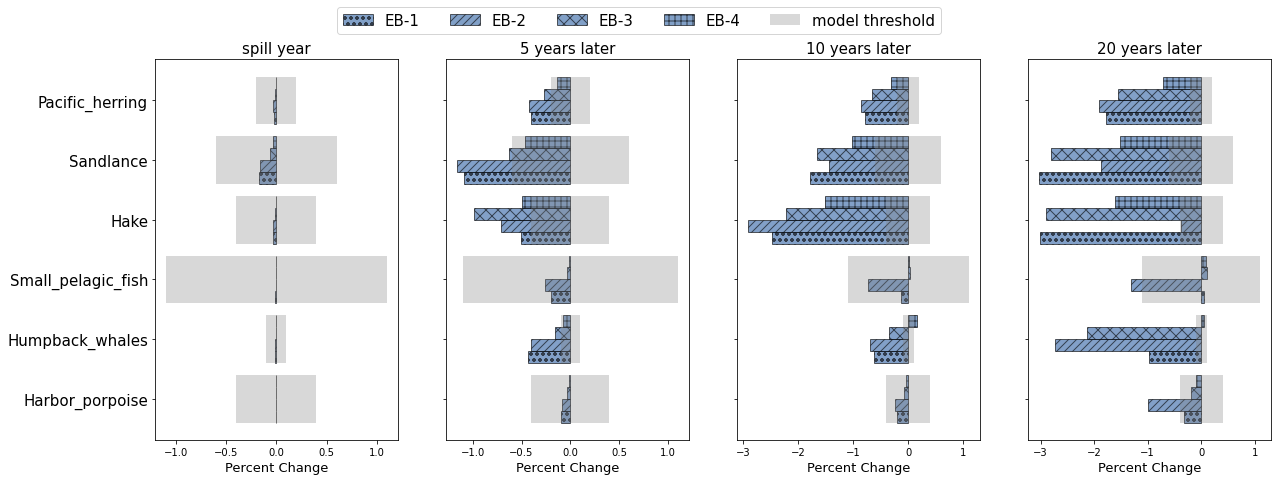

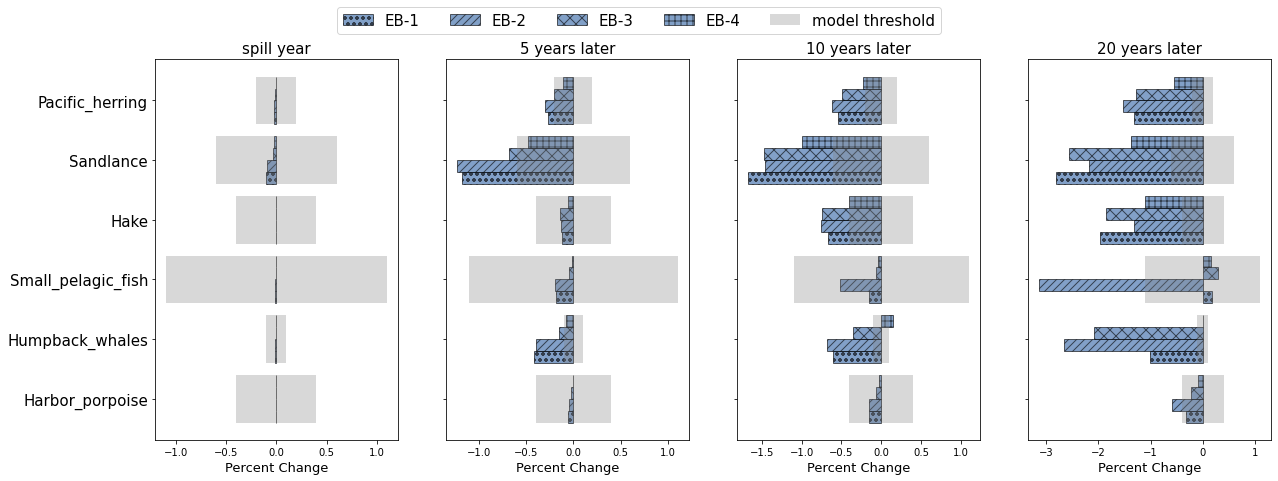

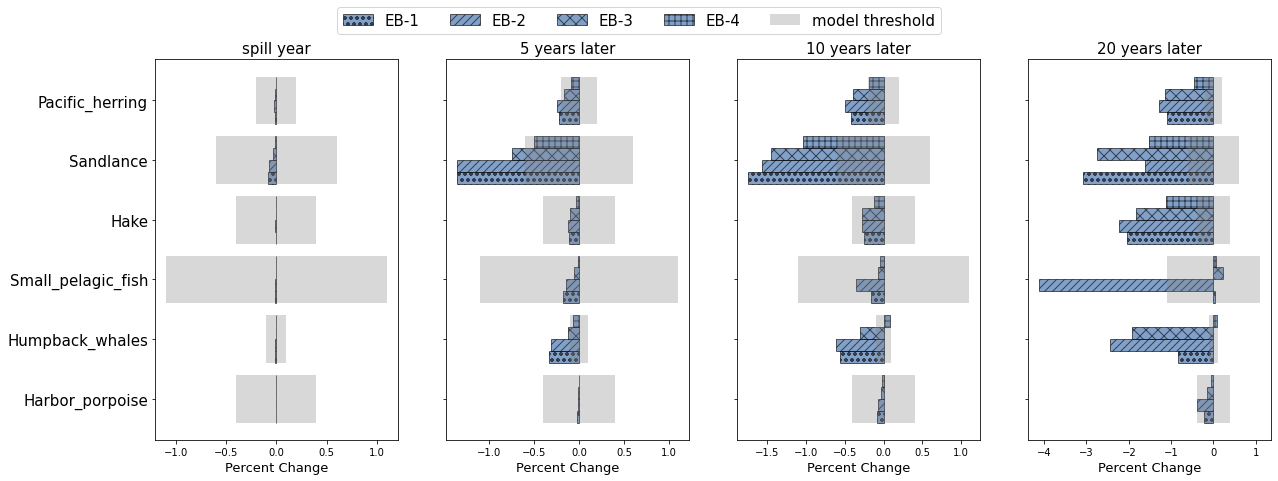

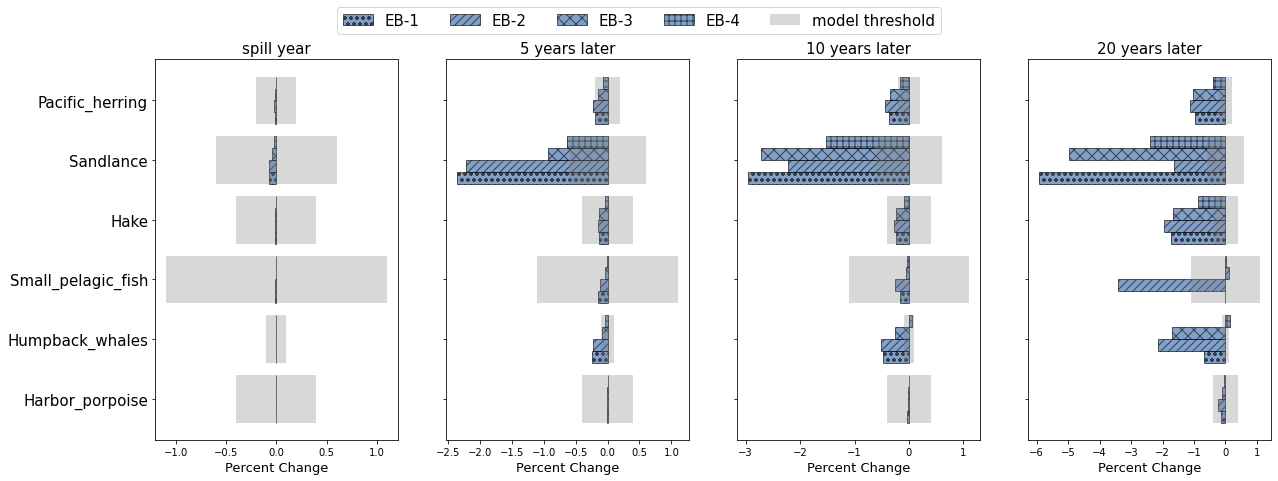

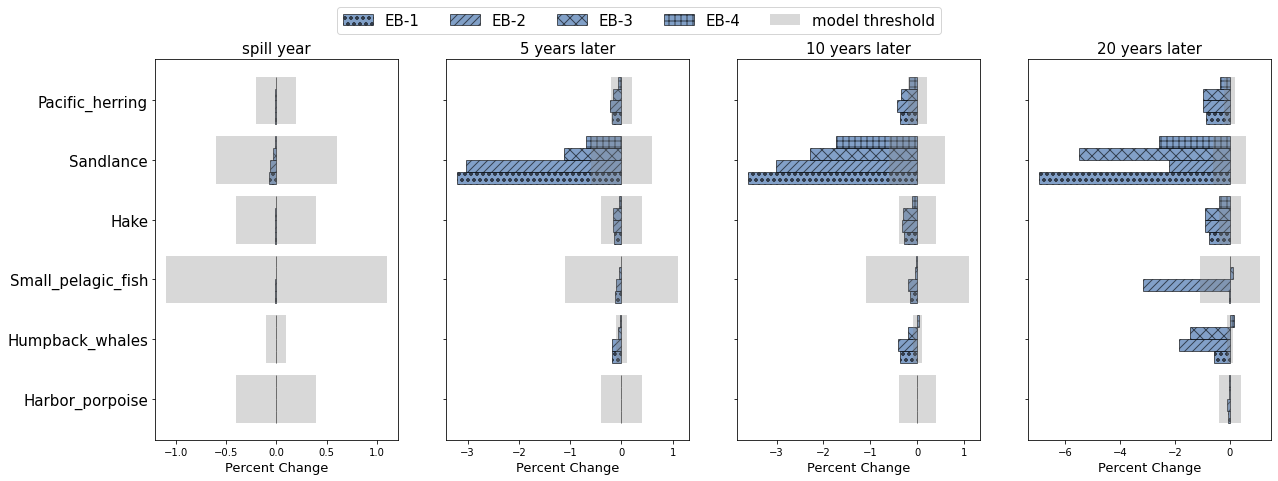

In [42]:
for cohort in range (1,8):
    progressive_boxplot_cohort(affected_pelagic, cohort)

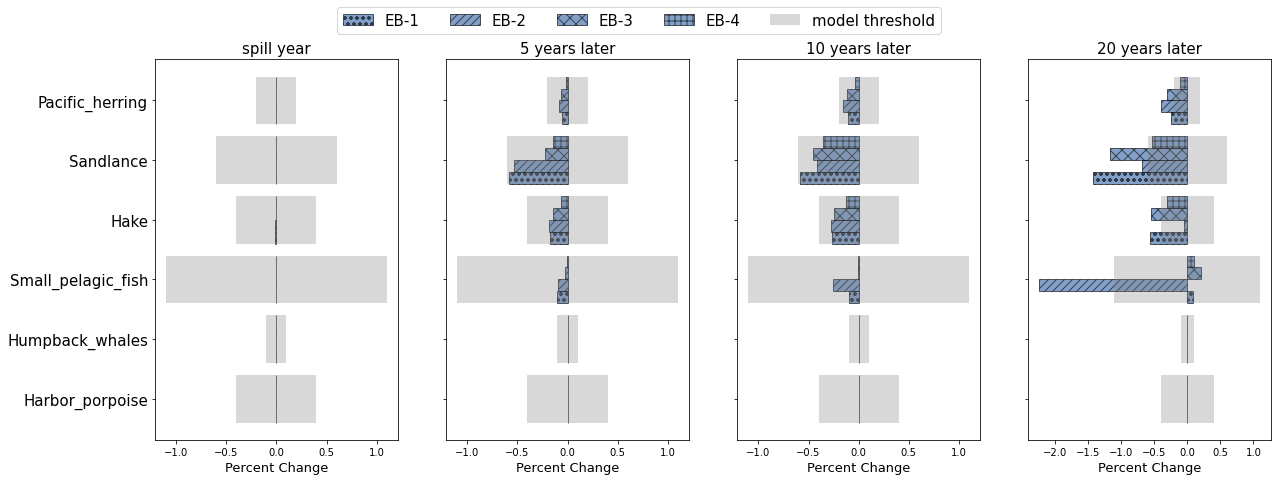

In [16]:
progressive_boxplot_numbers(affected_pelagic)

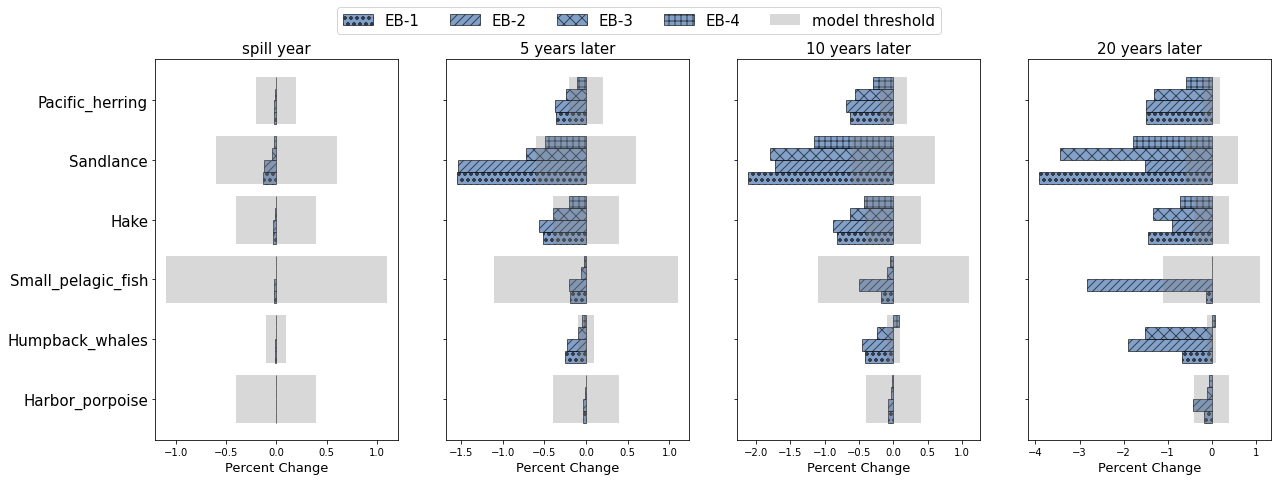

In [19]:
progressive_boxplot_vertebrates(affected_pelagic)

Plotting _Nums alone does not show the true range of change, as both weight and numbers of groups are affected by the scenario simulations, as observed in the difference between the last two plots. A large proportion of the change in sandlance, herring, and humpback whales is the decrease in weight as well as the decrease in numbers. 